# Exploring the radial properties of the hot-ICM temperature


<span style="color:red">This should currently be considered preliminary, as there are some problems with observation selection for spectral generation for some of these large clusters - also our improved background method isn't fully implemented. Also also, we are still using the MCXC defined coordinates</span>

<span style="color:red">**We do not currently make the temperature profile saves available, as I need to create a better file format for them (i.e. FITS based), and they are probably too large for GitHub right now.**</span>

## Import Statements

In [21]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
from shutil import rmtree
from matplotlib import pyplot as plt
import os

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 50
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sourcetools.temperature import min_cnt_proj_temp_prof  
from xga.sas.phot import emosaic
from xga.imagetools.misc import physical_rad_to_pix
from xga.exceptions import NoProductAvailableError
from xga.products import BaseAggregateProfile1D

%matplotlib inline

In [2]:
xga.__version__

'v0.4.3+2.gc1f8f78'

## Define the cosmology

We make use of a concordance flat LambdaCDM cosmology during the course of this analysis:

In [3]:
cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading the sample file

We read in the sample file to get the information we need to set up an XGA ClusterSample:

In [4]:
samp = pd.read_csv('../../outputs/results/ltr_r500_metfree_pipeline_results.csv')
rad_hist = pd.read_csv('../../outputs/results/ltr_r500_metfree_radii_history.csv')

samp = samp[~np.isnan(samp['r500'])]

temp_samp = samp.merge(rad_hist)
samp = samp[temp_samp['converged'].values]
samp.reset_index(drop=True, inplace=True)
samp

name          MCXC  LoVoCCSID LoVoCCS_name          ra        dec   
0     LoVoCCS-0  J1558.3+2713          0    LoVoCCS-0  239.585833  27.226944  \
1     LoVoCCS-3  J1348.8+2635          3    LoVoCCS-3  207.220833  26.595556   
2     LoVoCCS-6  J1524.1+2955          6    LoVoCCS-6  231.040833  29.921111   
3     LoVoCCS-7  J2201.9-5956          7    LoVoCCS-7  330.483333 -59.949444   
4     LoVoCCS-8  J1702.7+3403          8    LoVoCCS-8  255.678750  34.061944   
..          ...           ...        ...          ...         ...        ...   
74  LoVoCCS-131  J0910.6-1034        131  LoVoCCS-131  137.651250 -10.581111   
75  LoVoCCS-132  J0155.1+3355        132  LoVoCCS-132   28.789583  33.922222   
76  LoVoCCS-134  J2158.4-6023        134  LoVoCCS-134  329.613333 -60.399444   
77  LoVoCCS-138  J0314.3-4525        138  LoVoCCS-138   48.582500 -45.424167   
78  LoVoCCS-142  J0448.2-2028        142  LoVoCCS-142   72.050833 -20.469722   

    redshift sub_samp  old_LoVoCCSID         r500    Tx500    Tx500-   
0     0.0894    north              0  1241.126247  6.66983  0.035522  \
1     0.0622    north              3   935.622882  4.37809  0.023748   
2     0.1145    north              5  1094.977713  5.42252  0.081687   
3     0.0980    south              6  1144.008856  5.84815  0.060684   
4     0.0953    north              7  1059.477512  5.03418  0.035647   
..       ...      ...            ...          ...      ...       ...   
74    0.0916    south            128   989.208110  4.43327  0.161514   
75    0.0872    north            129   789.269333  2.98323  0.048755   
76    0.0750    south            131   843.076786  3.50032  0.102652   
77    0.0718    south            135   811.390455  3.09186  0.043594   
78    0.0720    south            139   855.576340  3.45248  0.136418   

      Tx500+  Lx500_0.5-2.0  Lx500_0.5-2.0-  Lx500_0.5-2.0+  Lx500_0.01-100.0   
0   0.035487   6.564412e+44    2.104242e+43    2.500167e+43      2.441745e+45  \
1   0.023603   3.720947e+44    6.203259e+41    4.910205e+41      1.138728e+45   
2   0.094523   1.781379e+44    6.892786e+41    1.074878e+42      5.999825e+44   
3   0.060664   1.424048e+44    9.513799e+41    1.180083e+42      4.985403e+44   
4   0.035674   2.920672e+44    7.967481e+41    7.170708e+41      9.554495e+44   
..       ...            ...             ...             ...               ...   
74  0.165918   1.032804e+44    1.282764e+42    1.925245e+42      3.169347e+44   
75  0.048715   1.015086e+44    8.947623e+41    7.355518e+41      2.631191e+44   
76  0.103270   5.061180e+43    4.659568e+41    6.224955e+41      1.396662e+44   
77  0.042141   8.333415e+43    4.411586e+41    3.640627e+41      2.193890e+44   
78  0.136196   4.341562e+43    8.113584e+41    7.921360e+41      1.191033e+44   

    Lx500_0.01-100.0-  Lx500_0.01-100.0+   Zmet500  Zmet500-  Zmet500+   
0        8.476728e+43       6.677272e+43  0.249044  0.007681  0.007649  \
1        3.722639e+42       2.501454e+42  0.259384  0.007142  0.007179   
2        4.093127e+42       4.390889e+42  0.186388  0.020446  0.021135   
3        3.705251e+42       4.414781e+42  0.240489  0.014471  0.014662   
4        4.304164e+42       2.757757e+42  0.279499  0.010813  0.010930   
..                ...                ...       ...       ...       ...   
74       5.808805e+42       6.673058e+42  0.198729  0.047762  0.050262   
75       2.902033e+42       3.913797e+42  0.166910  0.016827  0.017322   
76       1.850819e+42       2.096634e+42  0.113048  0.028267  0.029398   
77       1.826760e+42       1.431951e+42  0.351399  0.017850  0.018314   
78       3.540096e+42       2.930622e+42  0.096546  0.033467  0.035357   

    Tx500ce  Tx500ce-  Tx500ce+  Lx500ce_0.5-2.0  Lx500ce_0.5-2.0-   
0   6.79410  0.061338  0.062129     3.859586e+44      2.108788e+43  \
1   4.40897  0.048821  0.048816     1.894150e+44      6.939636e+41   
2   5.35726  0.082606  0.083613     1.644362e+44      6.965629e+41   
3   5.63771  0.080044  0.080046     7.06108

## Set up an XGA ClusterSample

<span style="color:red">This is currently a bodge, they are some slightly better coordinates to help XGA select the correct region during the set up process. This will be made redundant by updated central positions for the whole sample sometime soon</span>

In [5]:
# samp.loc[95, 'ra'] = 240.56
# samp.loc[95, 'dec'] = 15.965

# samp.loc[130, 'ra'] = 359.713
# samp.loc[130, 'dec'] = -60.642

# samp.loc[89, 'ra'] = 227.865
# samp.loc[89, 'dec'] = 6.349

We set up an XGA ClusterSample to help us manage all the data and analyse the objects. <span style="color:red">The MCXC coordinates are used</span> as the central positions of the clusters, <span style="color:red">as well as the MCXC $R_{500}$ values.</span> 

<span style="color:red">The threshold for an observation being determined as relevant is set to 70% of the $R_{500}$ being on a particular observation.</span> 

In [6]:
# This one had that fucking 'None has no usable attribute error'
samp = samp[~samp.index.isin([65])]

In [7]:
ra = samp['ra'].values
dec = samp['dec'].values
name = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x)).values
z = samp['redshift'].values
r500 = Quantity(samp['r500'].values, 'kpc')

srcs = ClusterSample(ra, dec, z, name, r500=r500, use_peak=False, clean_obs=True, clean_obs_reg='r500', 
                     clean_obs_threshold=0.7, cosmology=cosmo, load_fits=True)

Declaring BaseSource Sample:   0%|          | 0/78 [00:00<?, ?it/s]/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
Setting up Galaxy Clusters:   0%|          | 0/78 [00:00<?, ?it/s]/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division
Setting up Galaxy Clusters: 100%|██████████| 78/78 [08:05<00:00,  6.22s/it]
/mnt/ufs18/home-218/turne540/code/XGA/xga/samples/extended.py:246: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


## Removing problematic observations

In [13]:
srcs['LoVoCCS-40'].disassociate_obs({'0502671101': ['mos2']})

## Generating projected temperature and metallicity profiles

In [16]:
rads = min_cnt_proj_temp_prof(srcs, srcs.r500, Quantity(1500, 'ct'), one_rmf=False, freeze_met=False)

ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_dev/lib/python3.9/site-packages/regions-0.4-py3.9-linux-x86_64.egg/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division
Generating products of type(s) annular spectrum set components: 100%|██████████| 28/28 [20:11<00:00, 43.26s/it]  
Running XSPEC Fits:  36%|███▌      | 553/1550 [2:00:23<3:21:10, 12.11s/it] /mnt/ufs18/home-218/turne540/code/XGA/xga/xspec/run.py:59: UserWarning: An XSPEC fit for LoVoCCS-20 has timed out
  warnings.warn("An XSPEC fit for {} has timed out".format(source_name))
Running XSPEC Fits: 100%|██████████| 1550/1550 [5:45:40<00:00, 13.38s/it]  
/mnt/ufs18/home-218/turne540/code/XGA/xga/xspec/run.py:326: UserWarning: LoVoCCS-0 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra pro

LoVoCCS-0


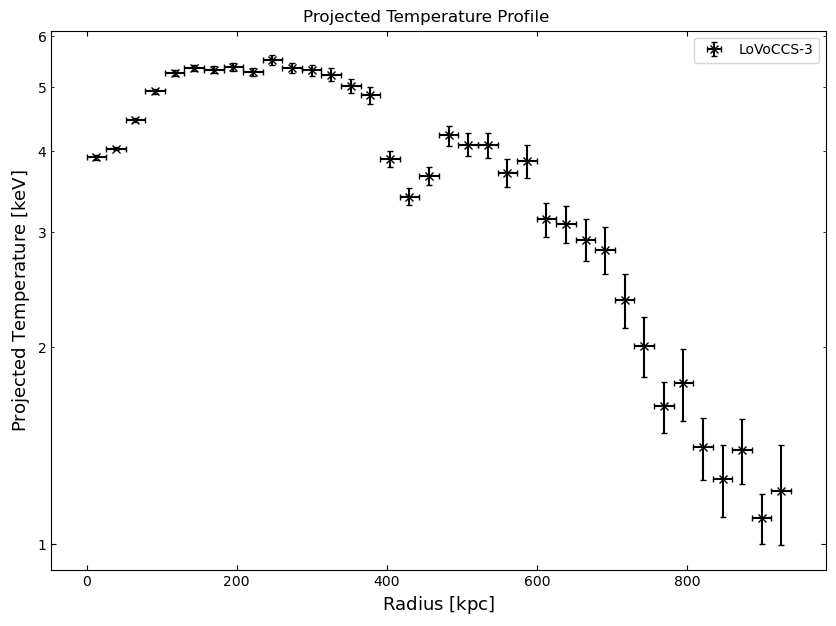

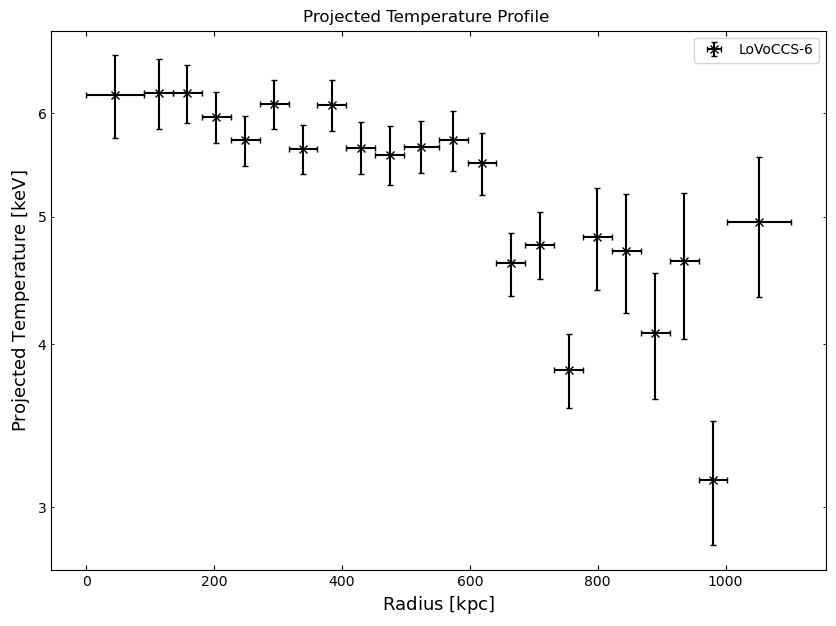

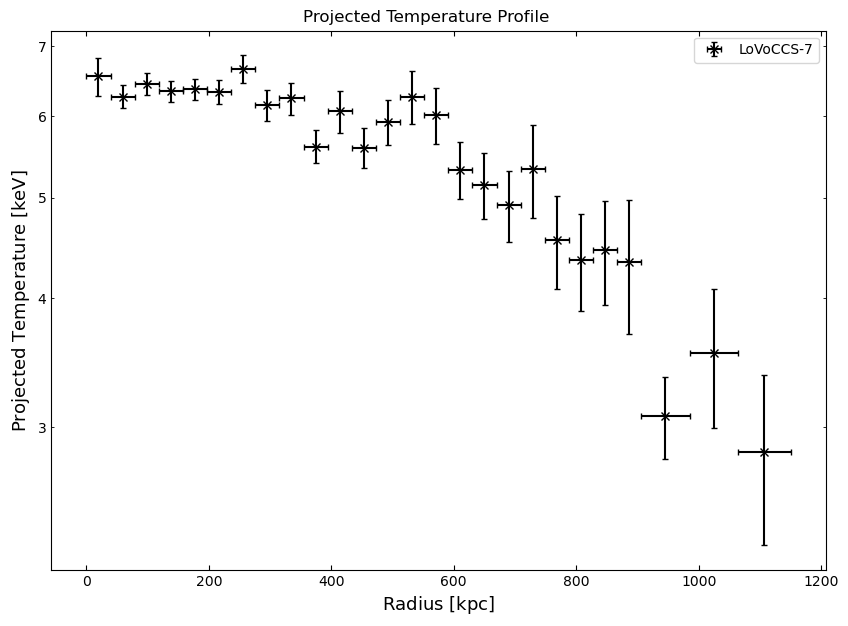

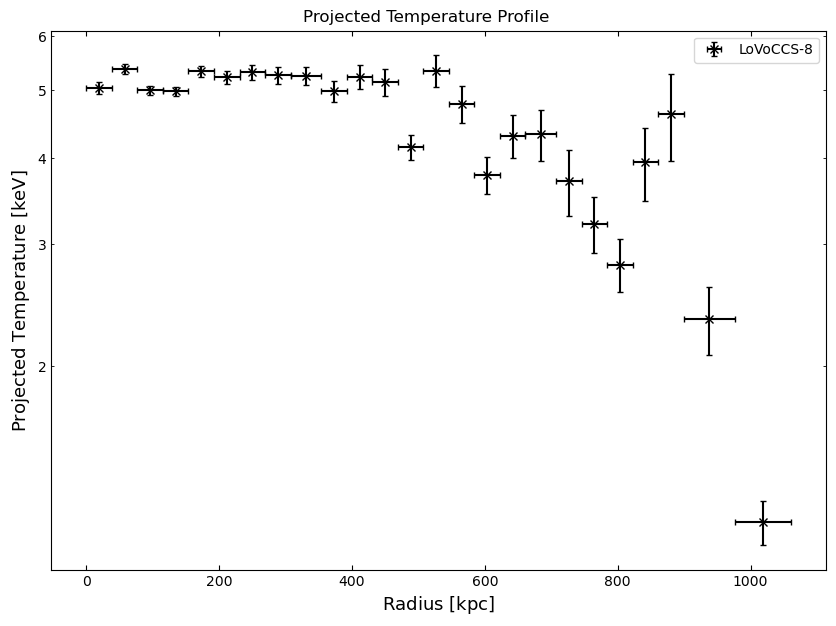

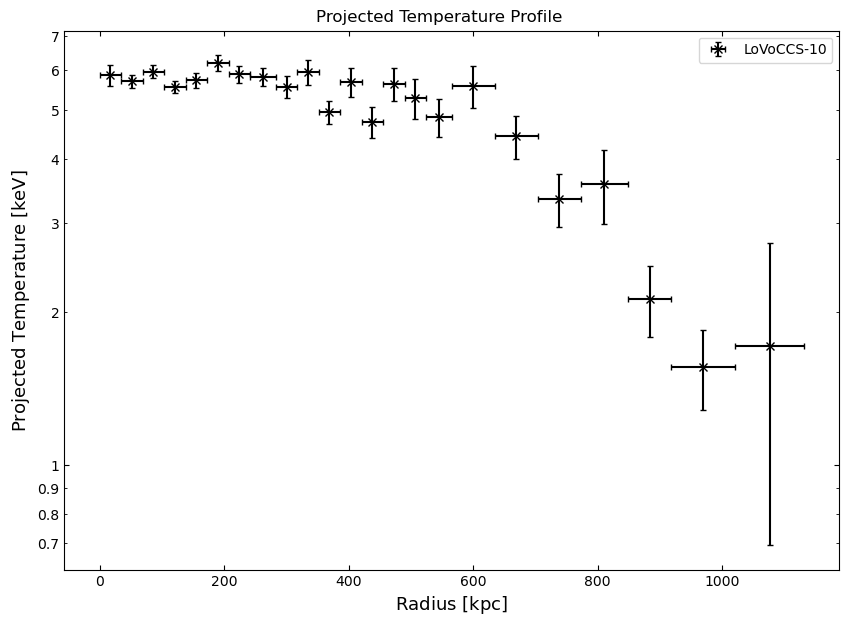

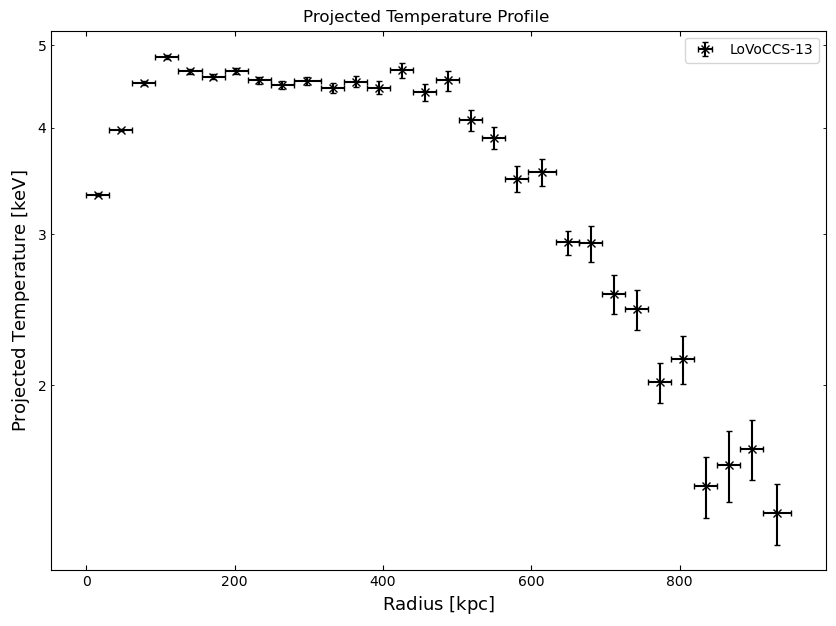

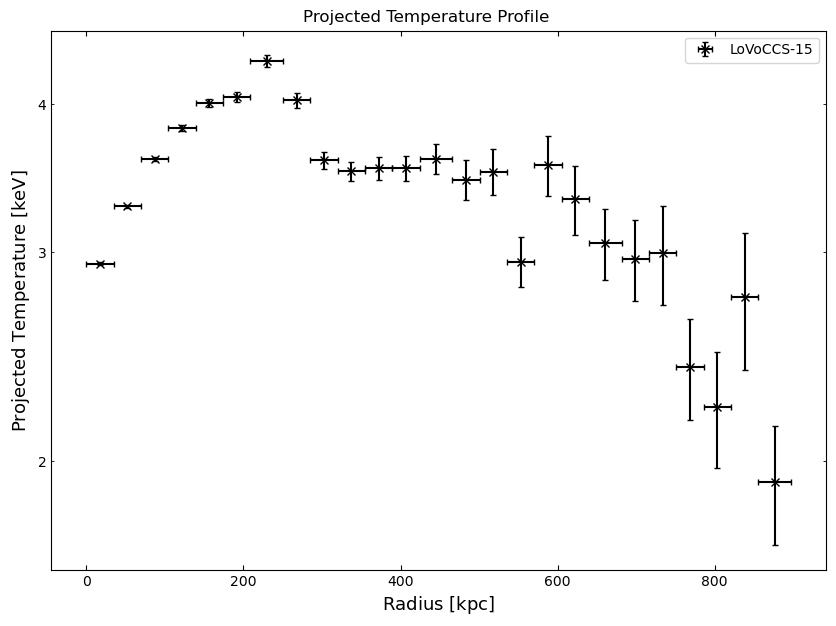

LoVoCCS-17


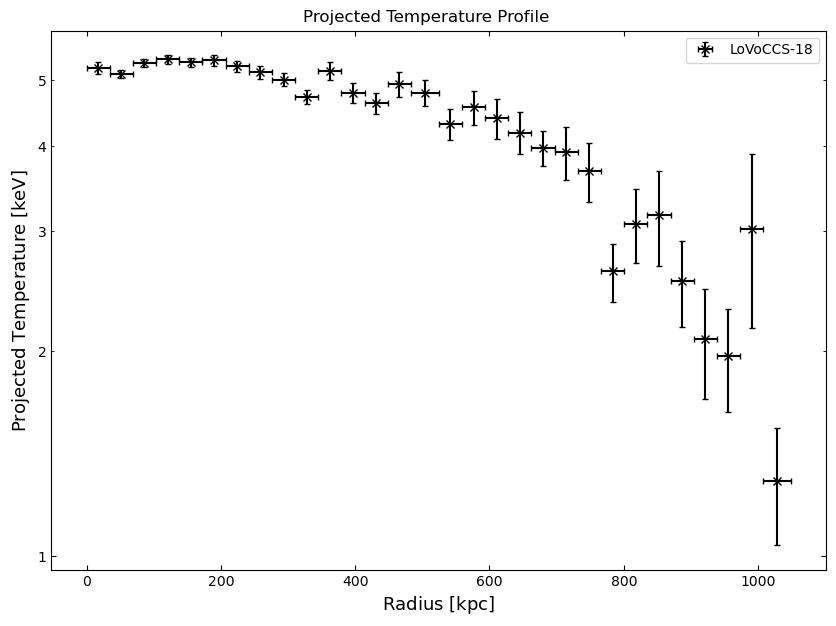

LoVoCCS-20
LoVoCCS-22


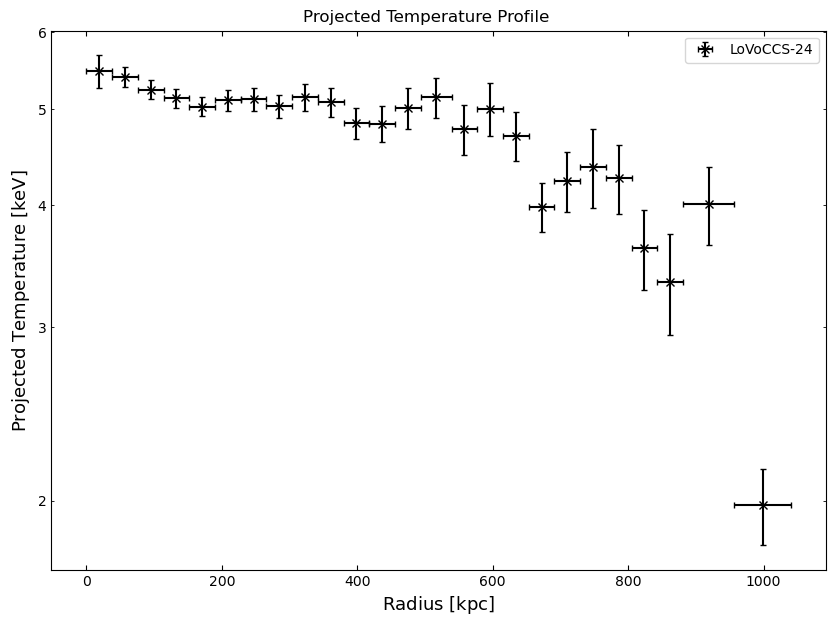

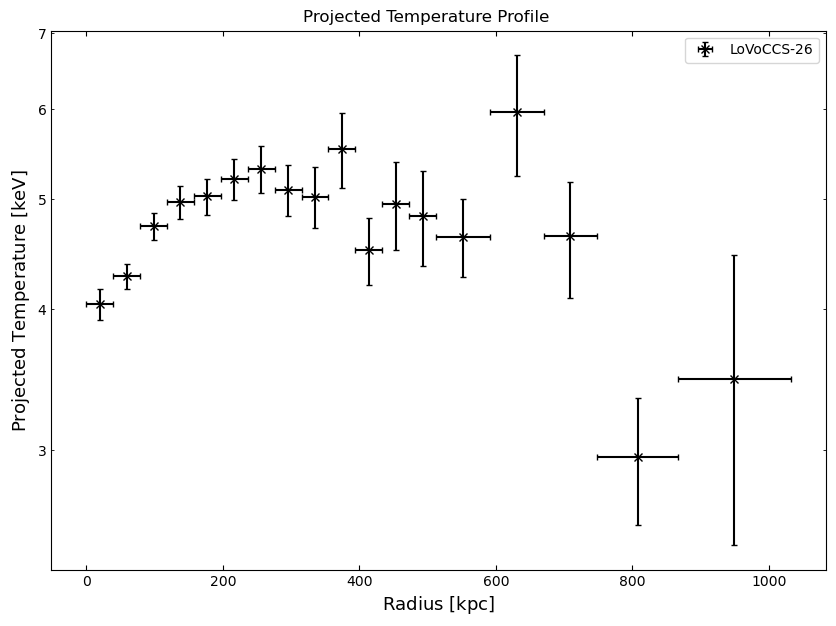

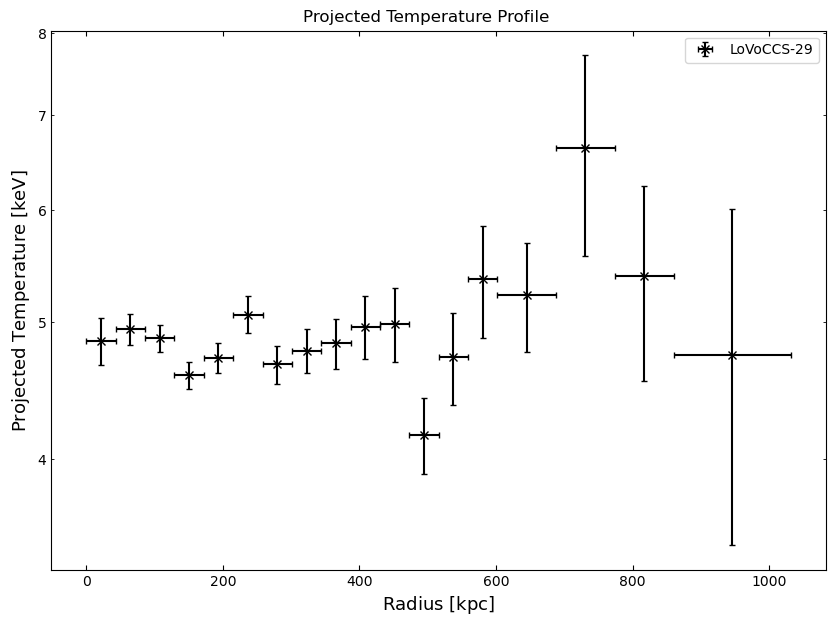

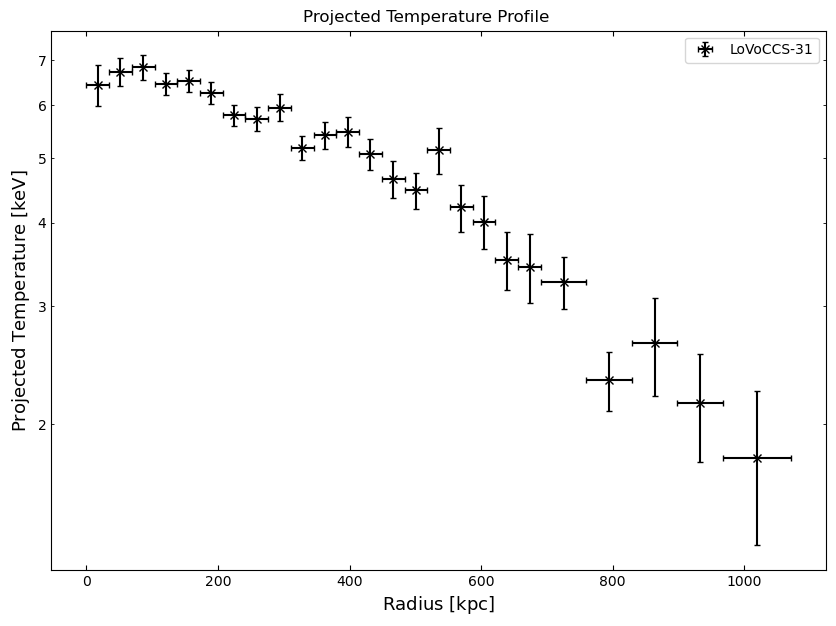

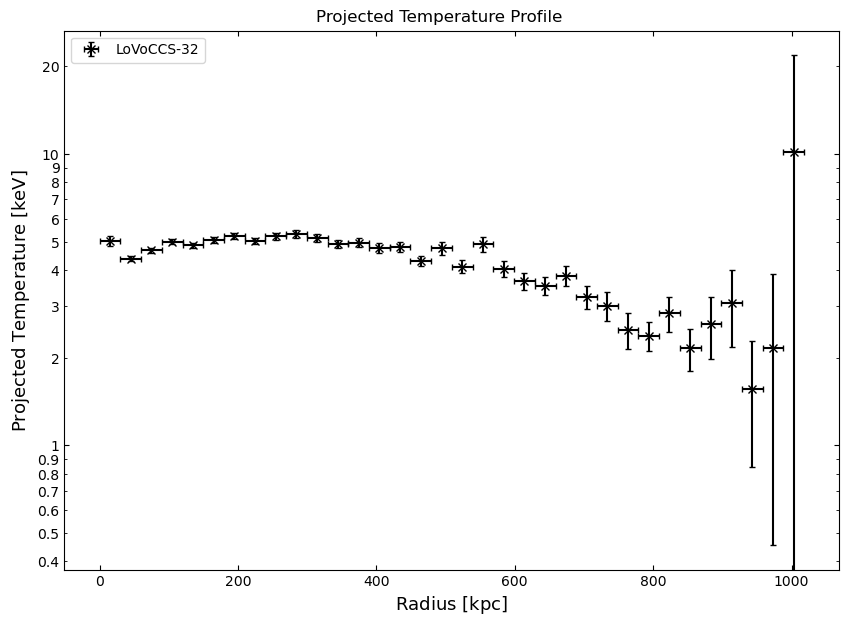

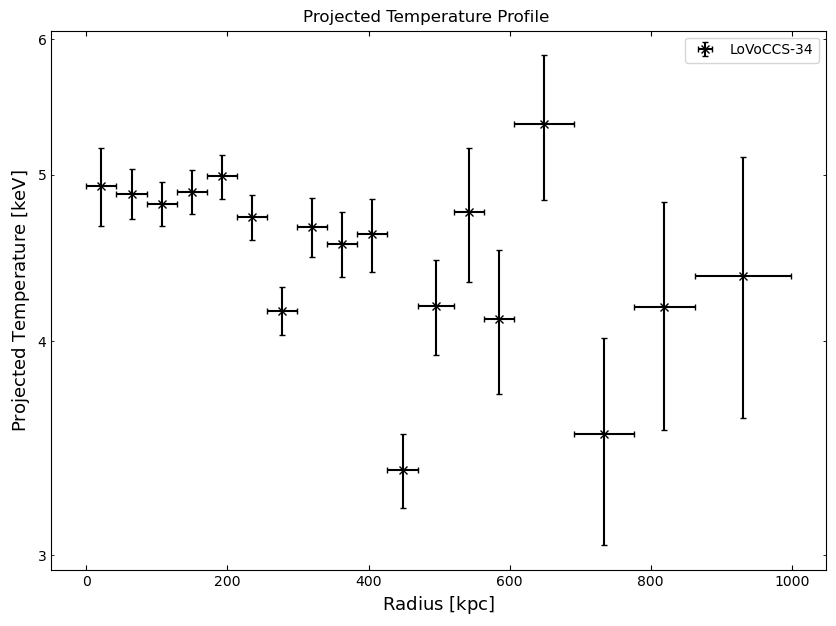

LoVoCCS-35


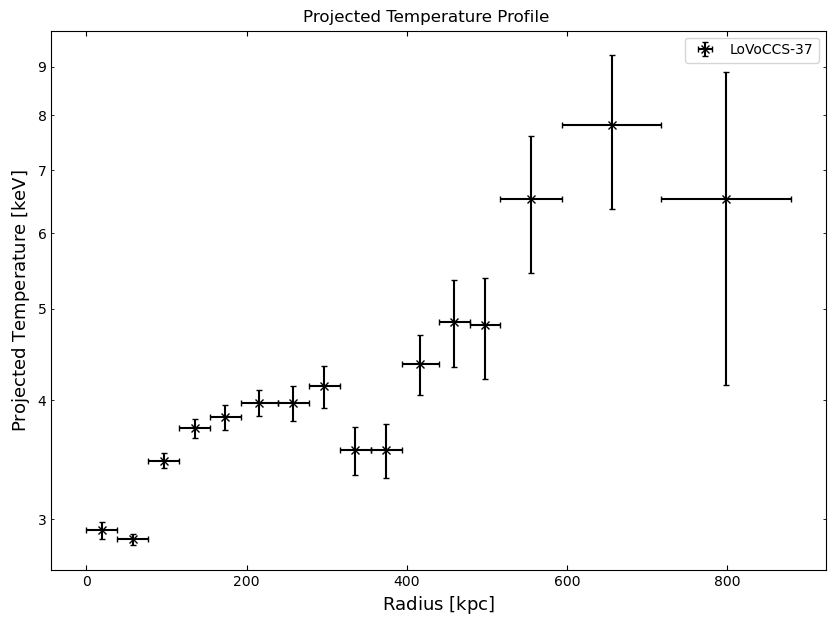

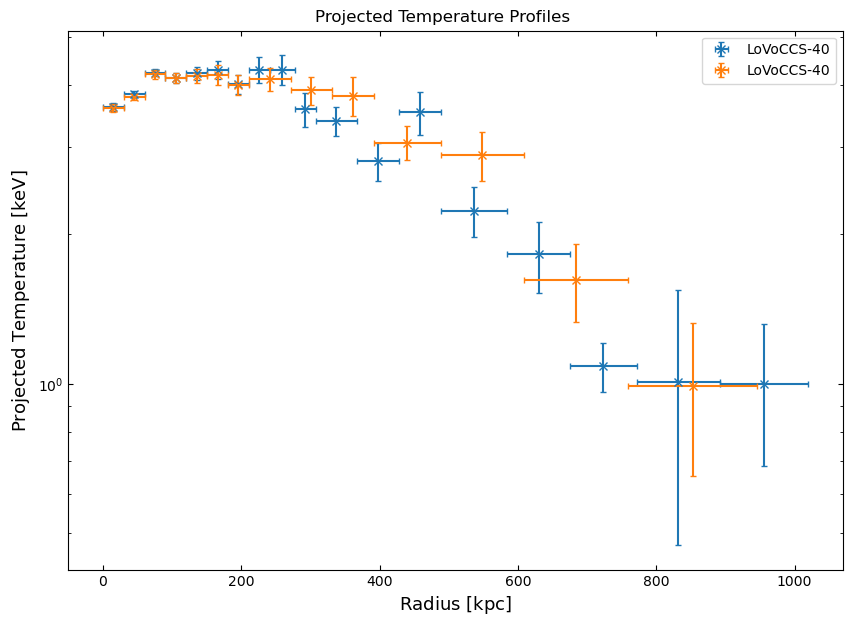

LoVoCCS-41


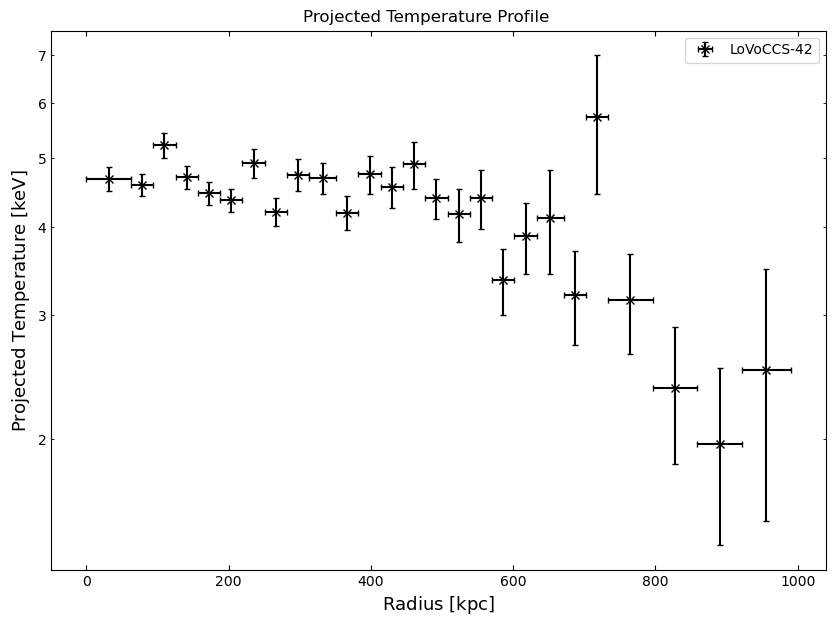

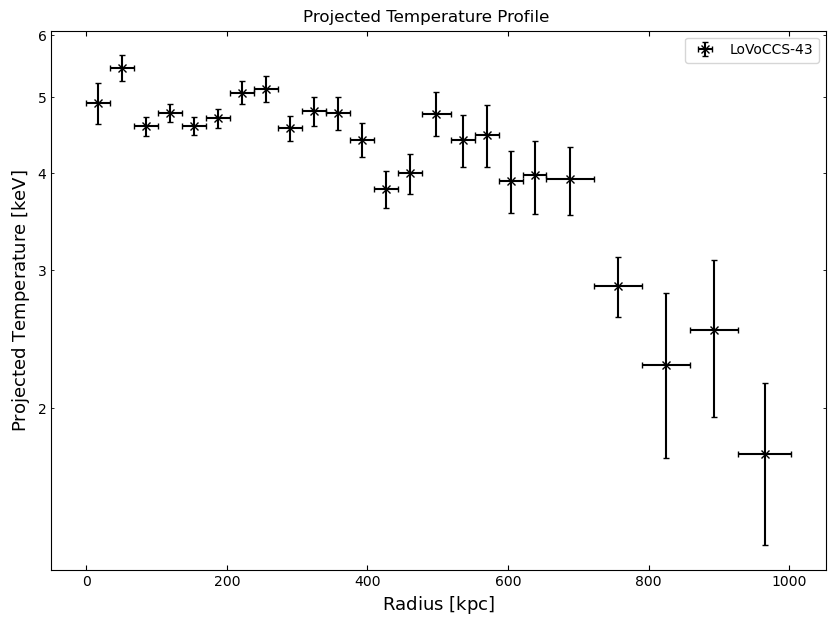

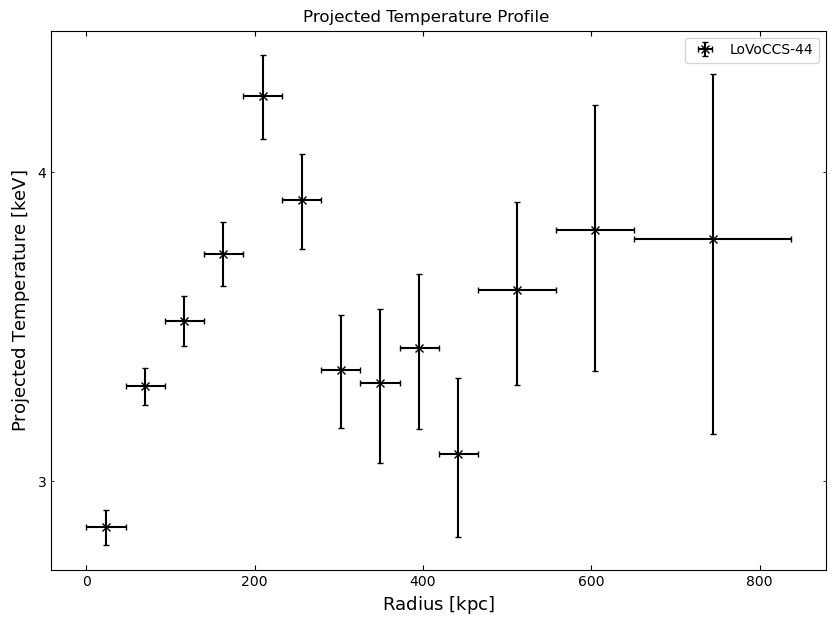

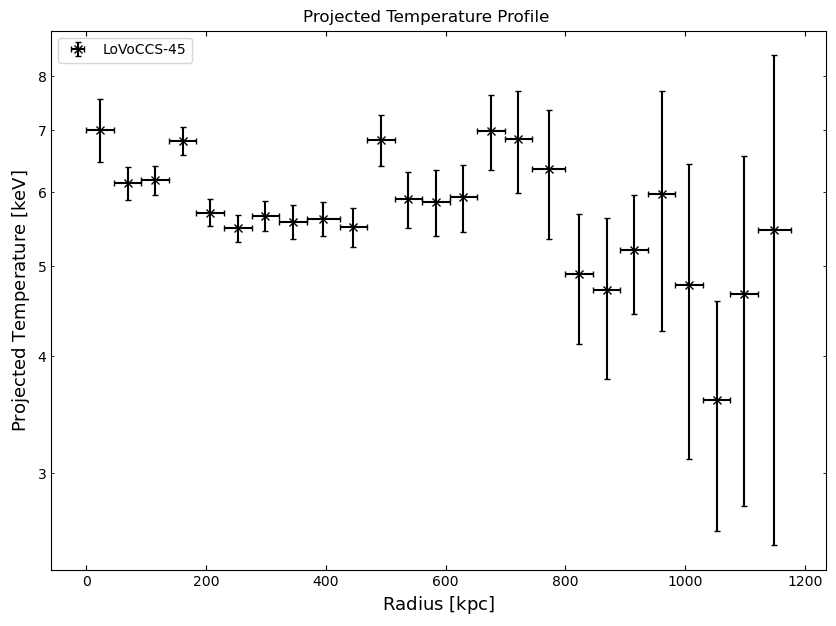

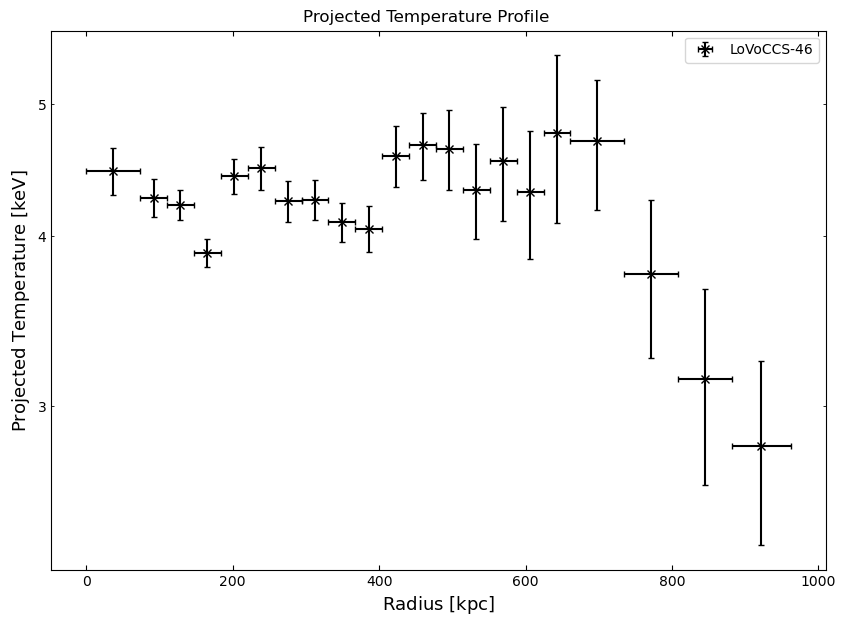

LoVoCCS-48


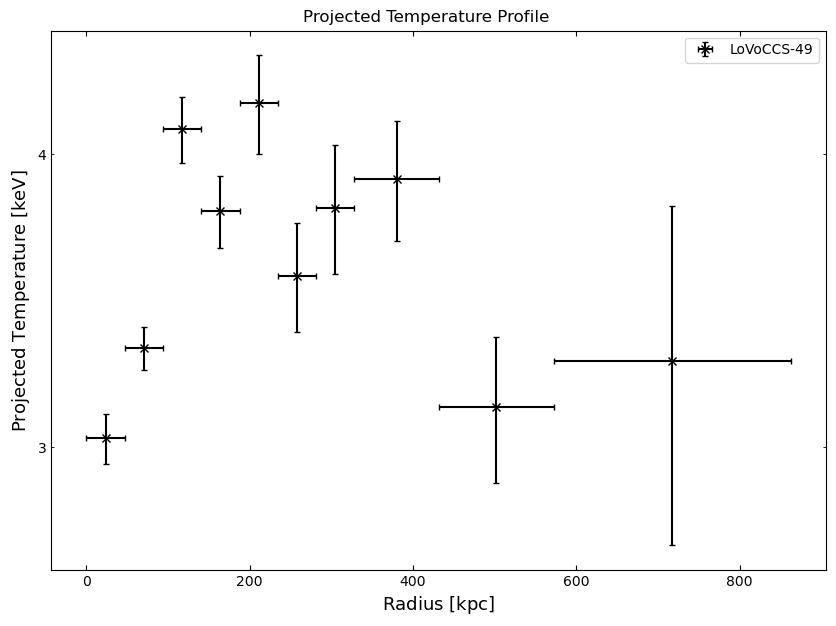

LoVoCCS-50
LoVoCCS-51


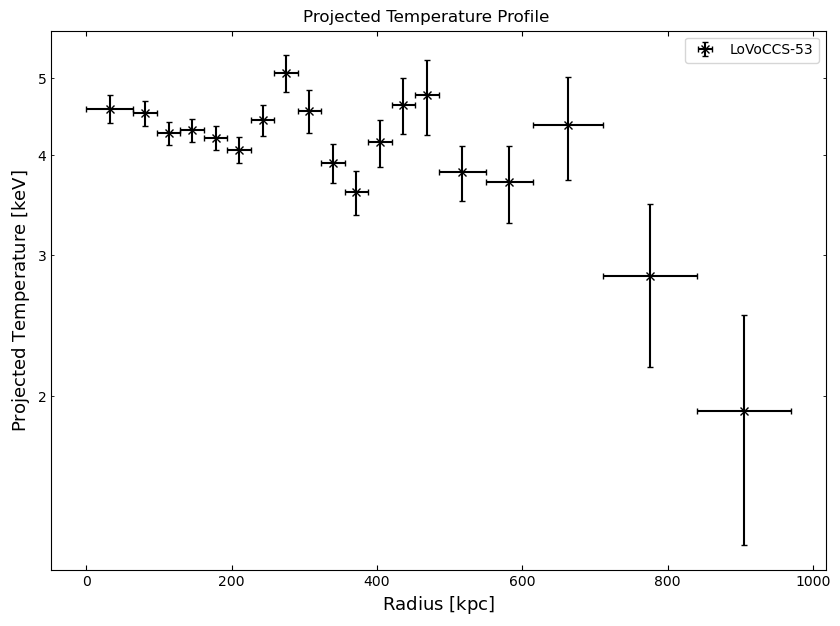

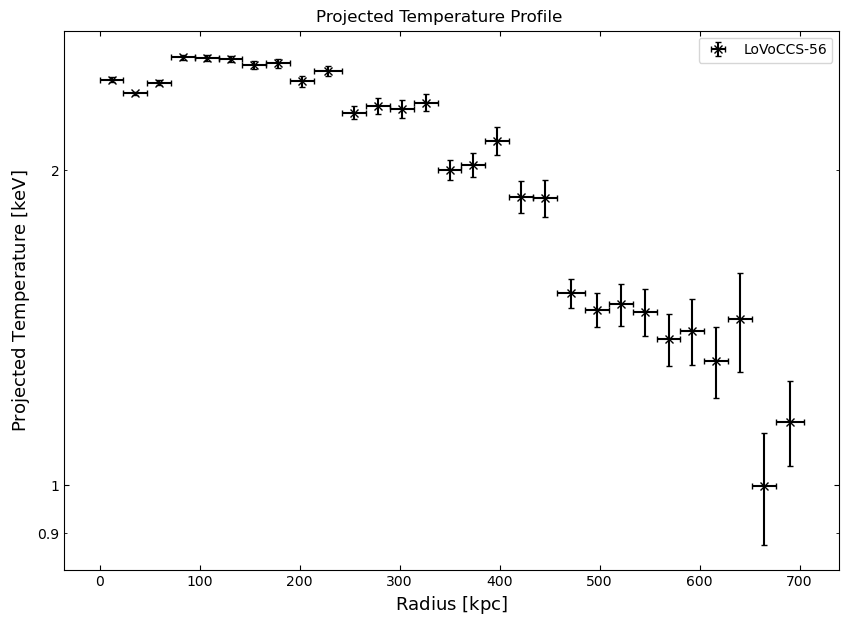

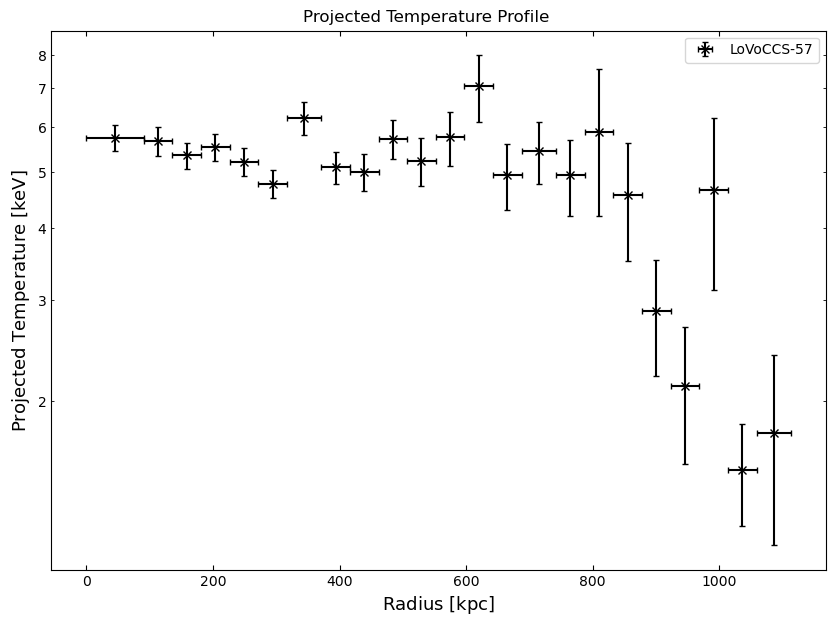

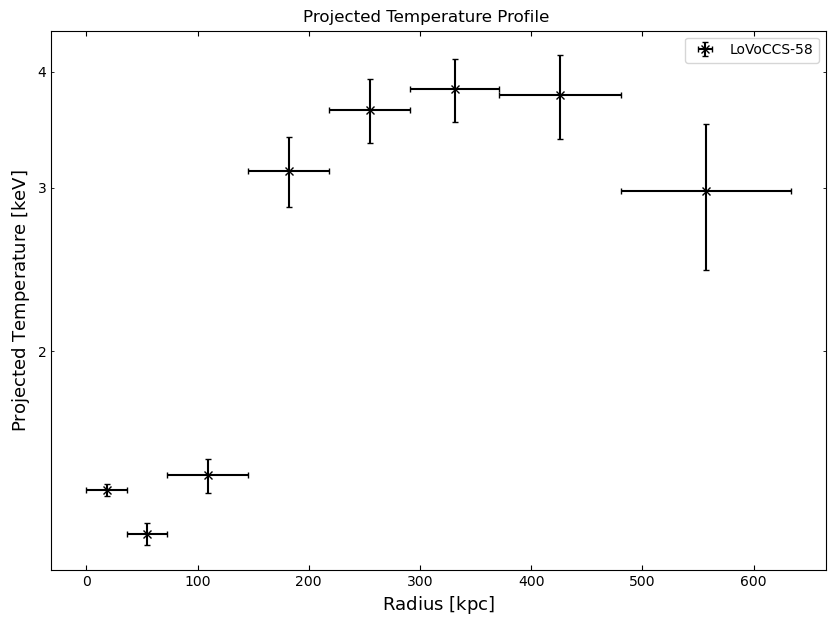

LoVoCCS-59


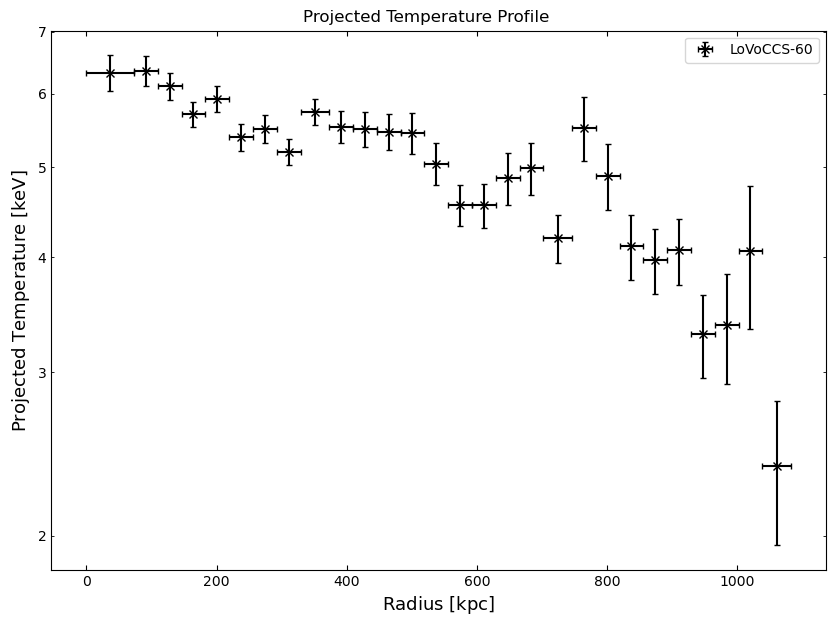

LoVoCCS-61
LoVoCCS-63


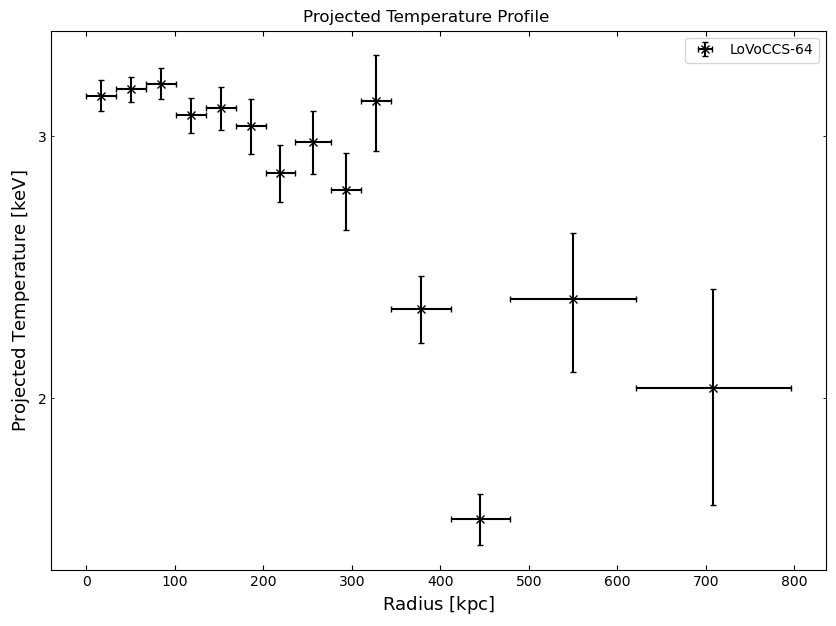

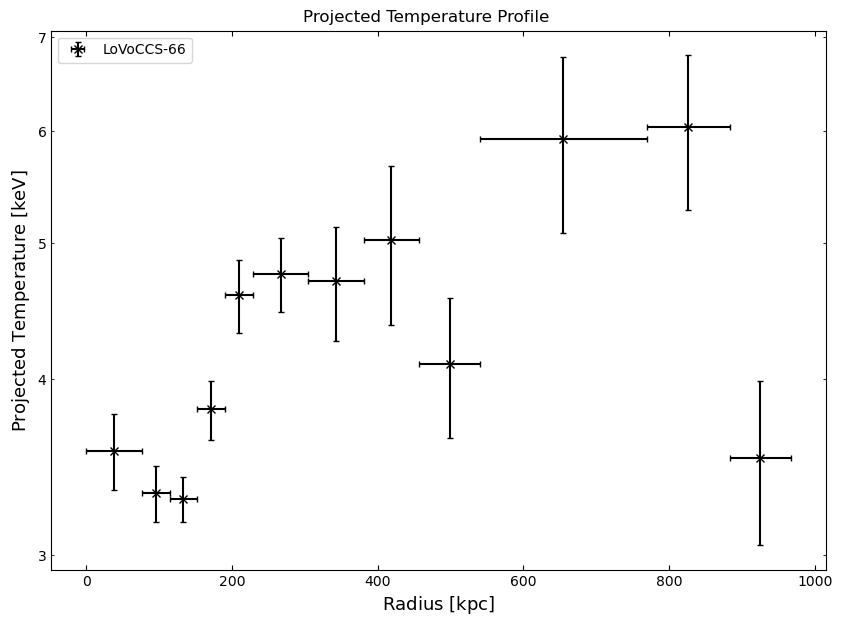

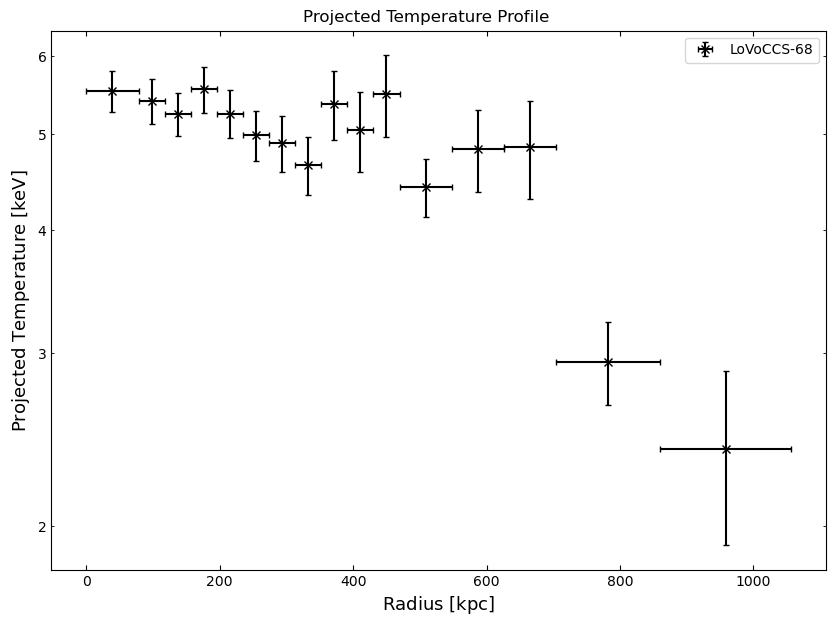

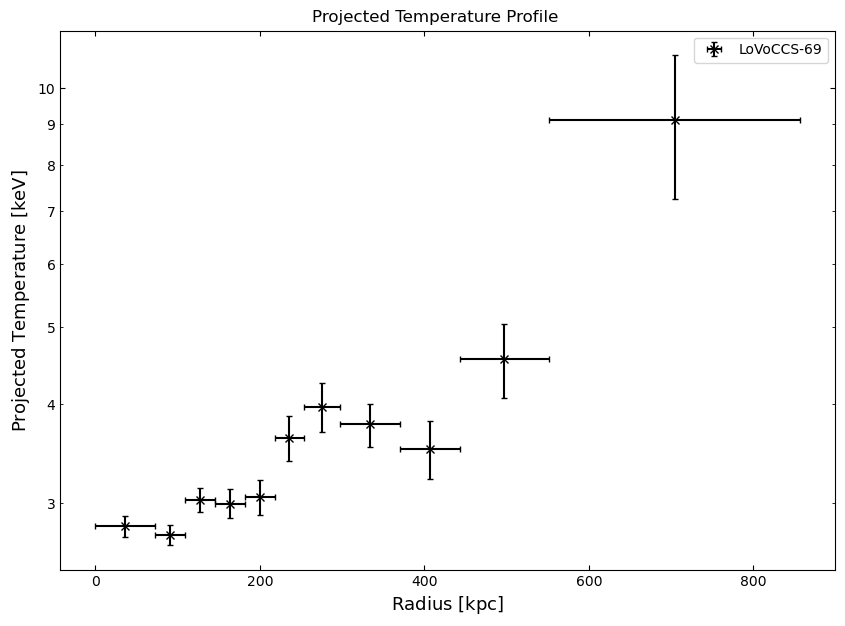

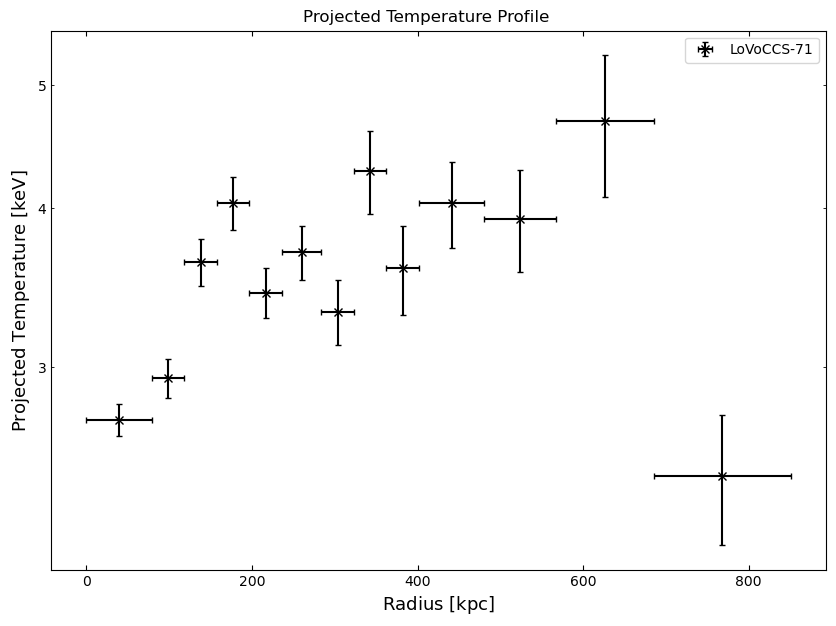

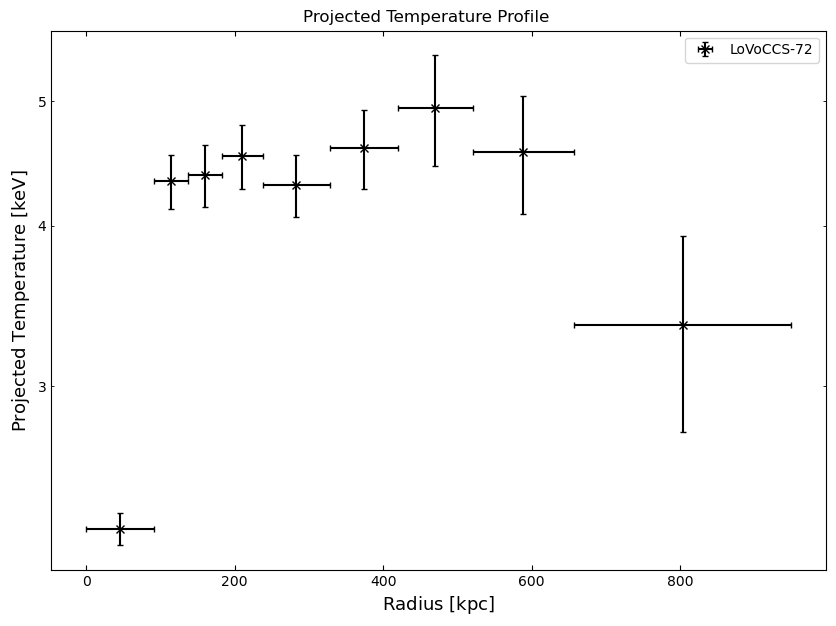

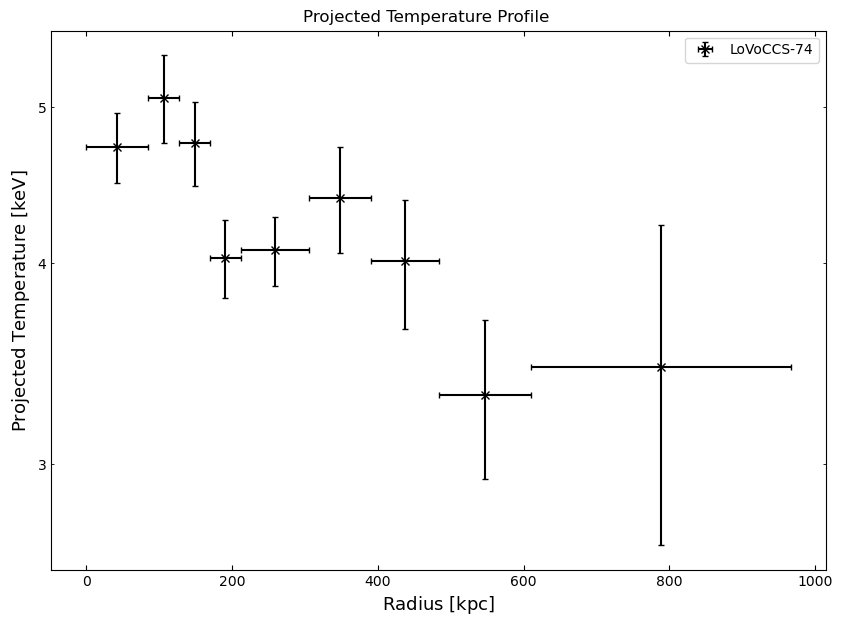

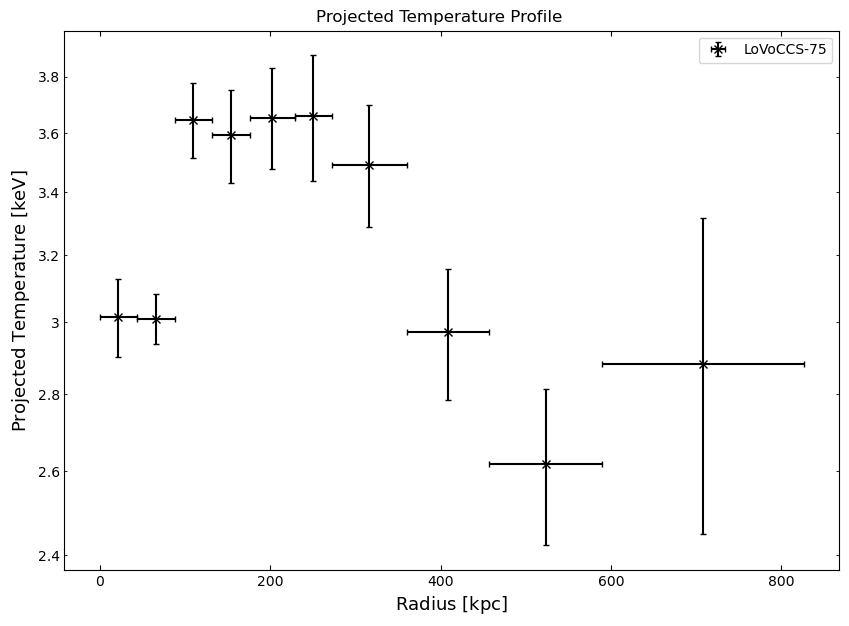

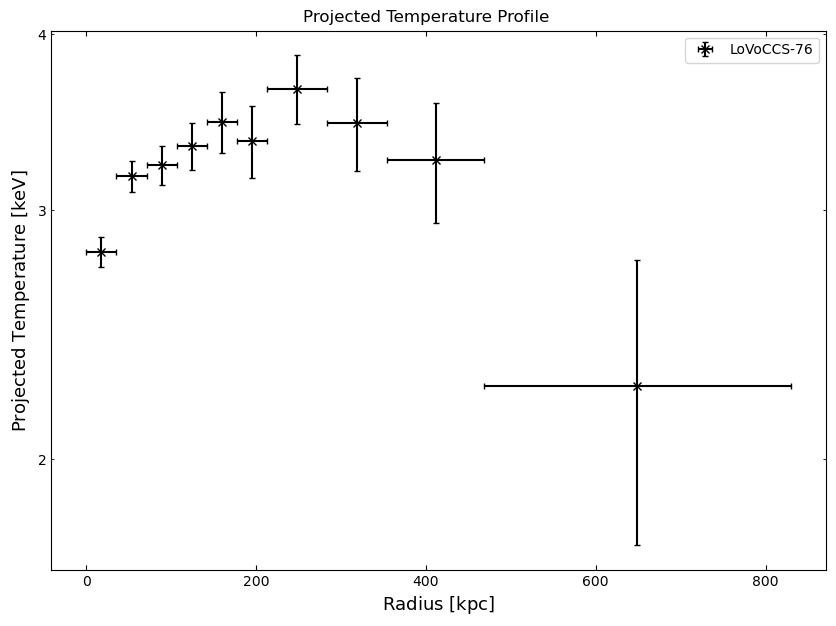

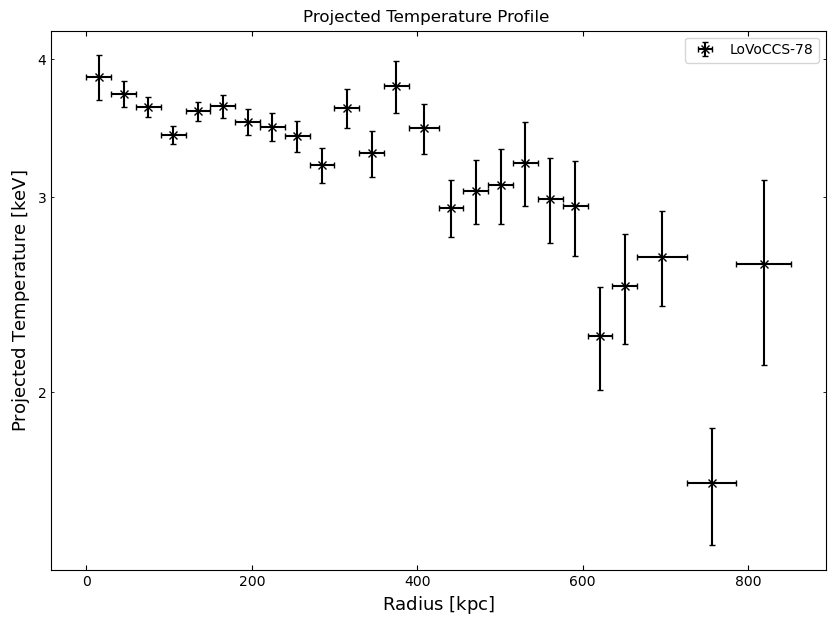

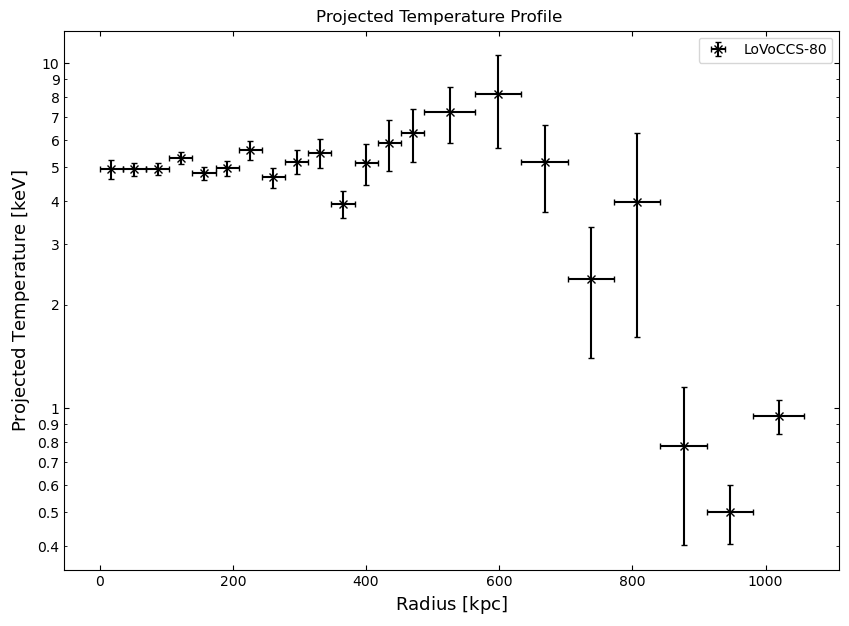

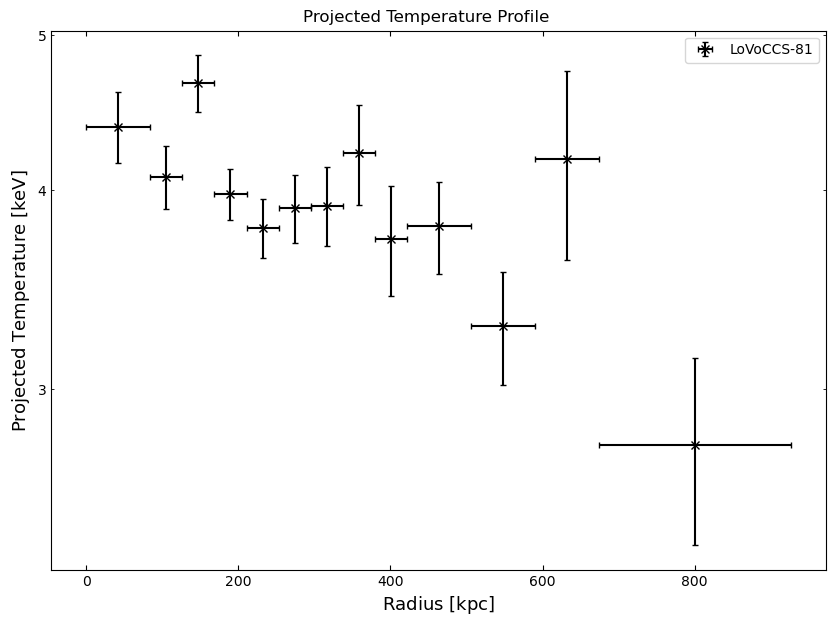

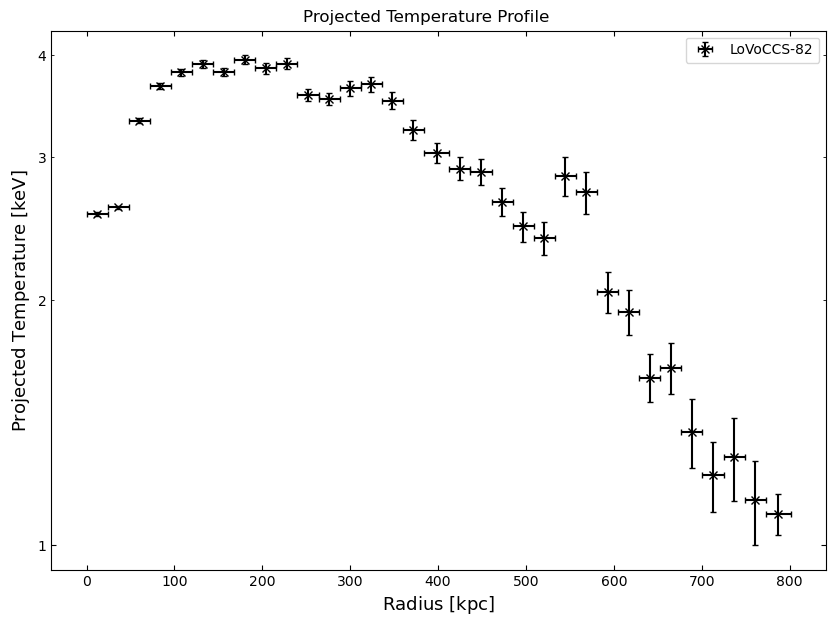

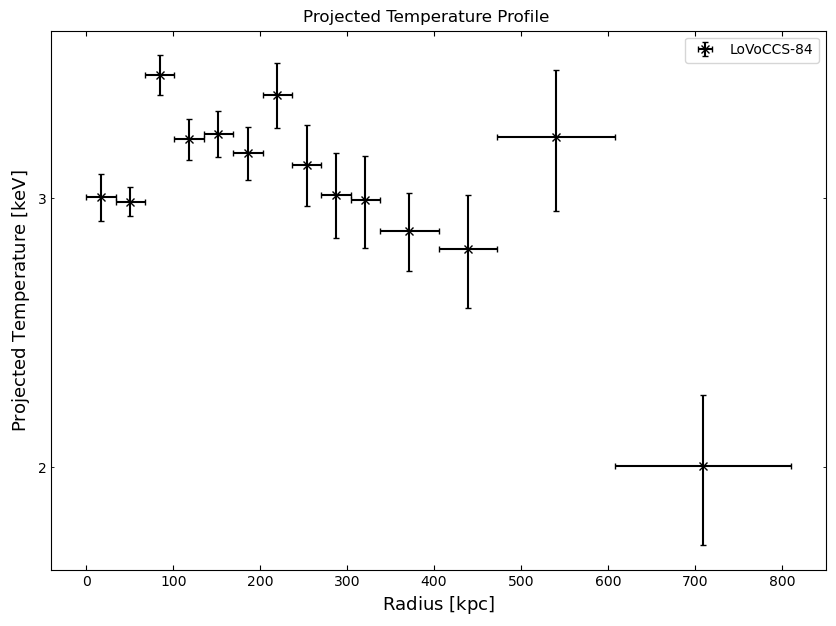

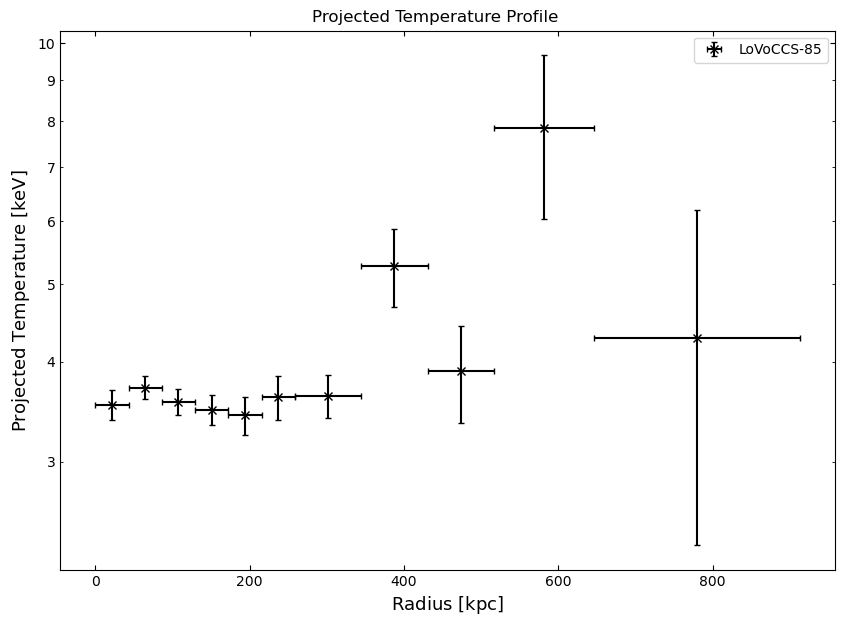

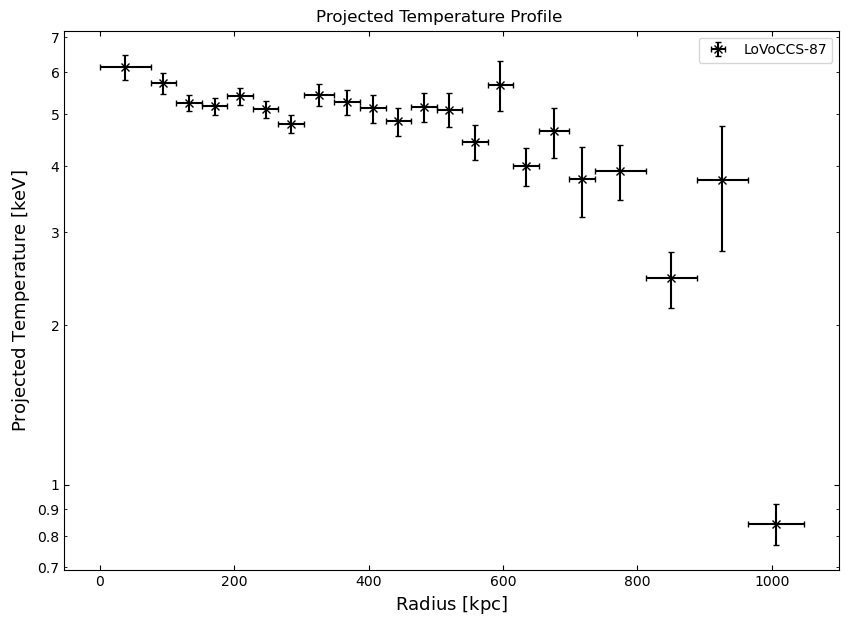

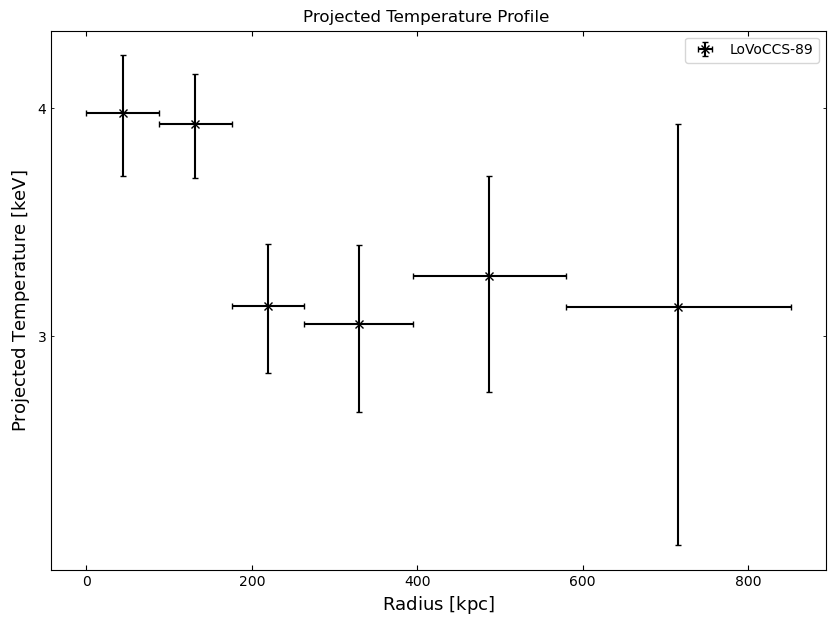

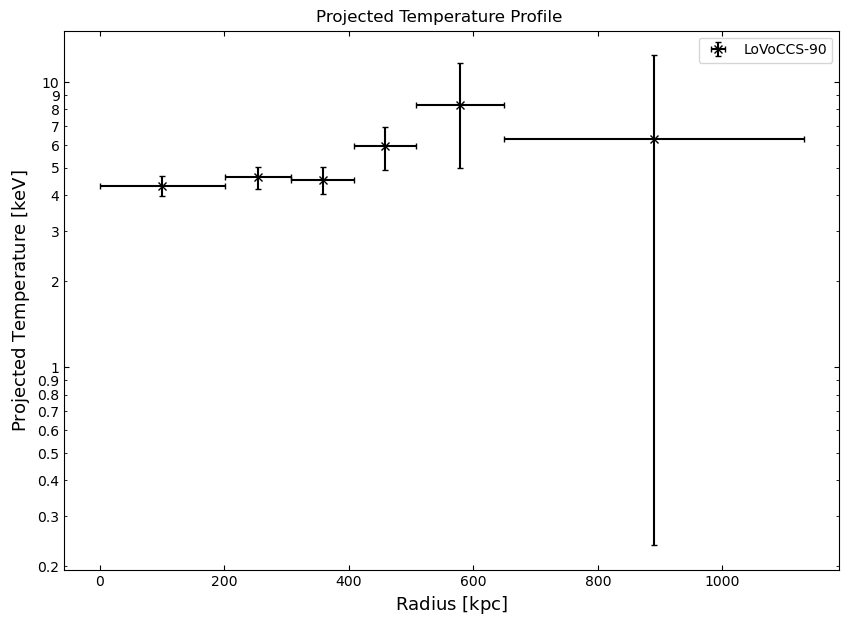

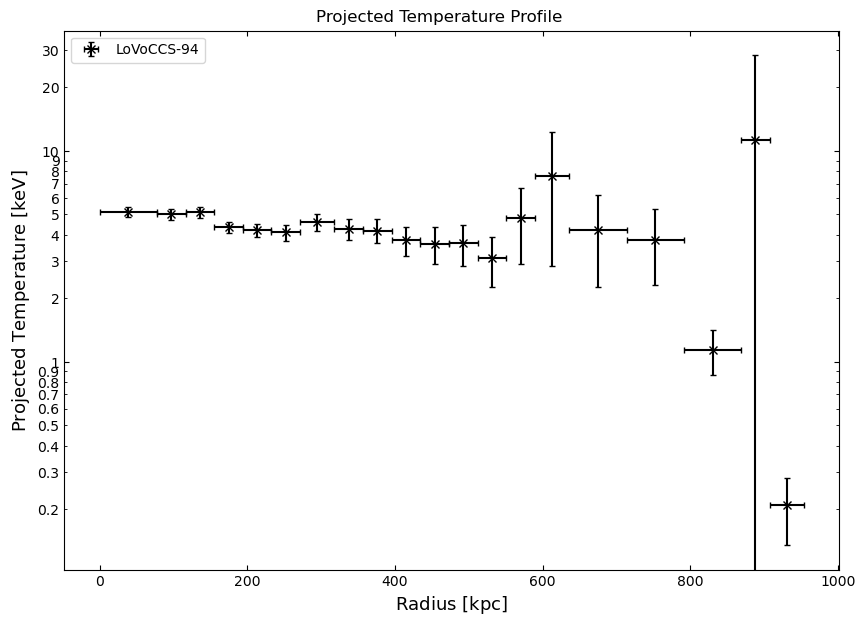

LoVoCCS-95
LoVoCCS-96


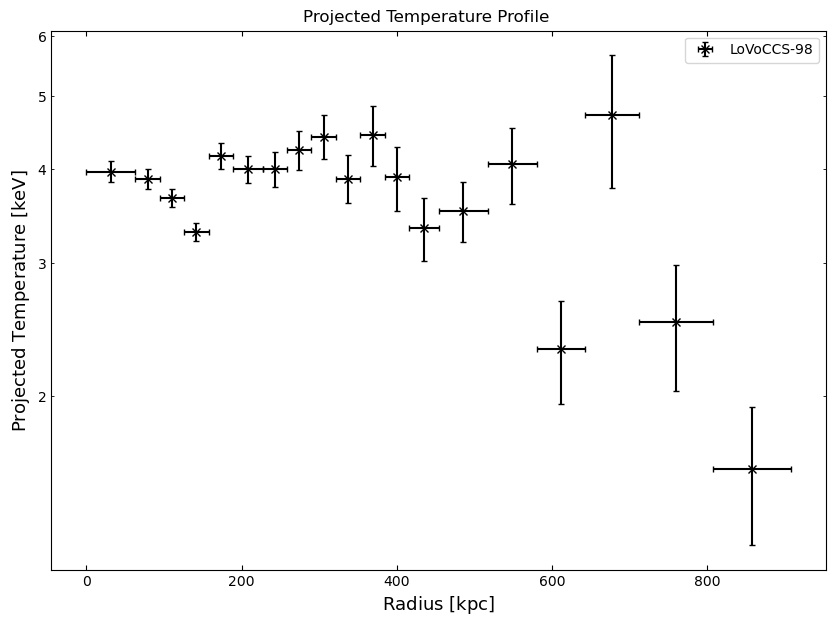

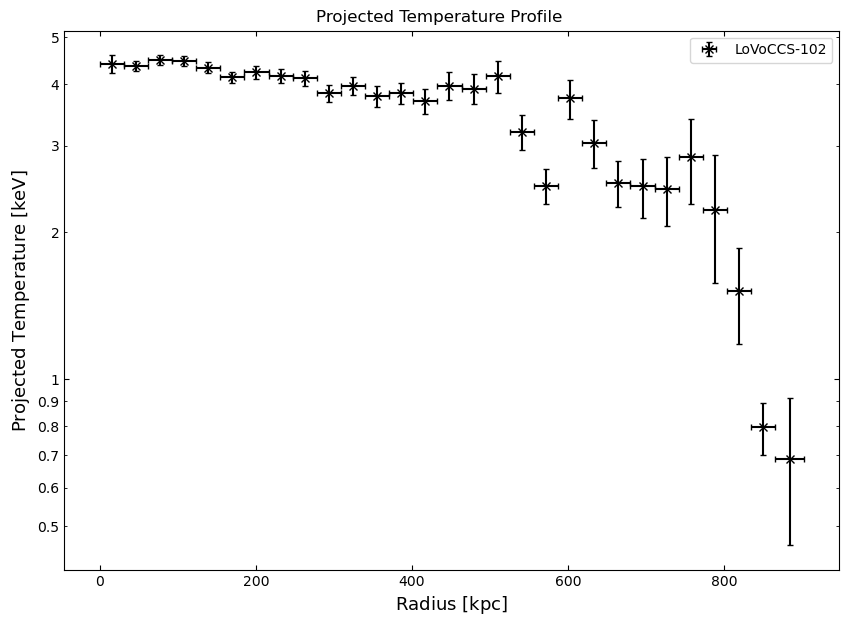

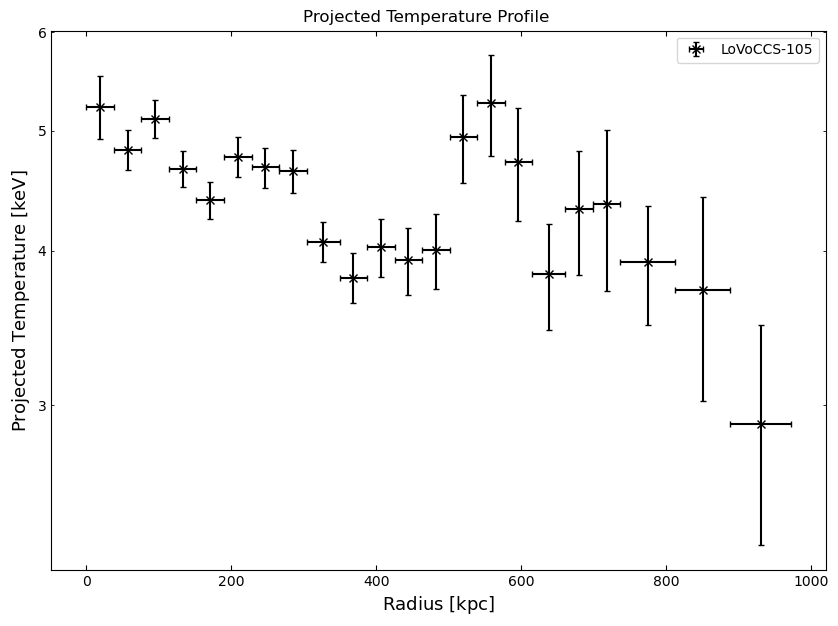

LoVoCCS-106


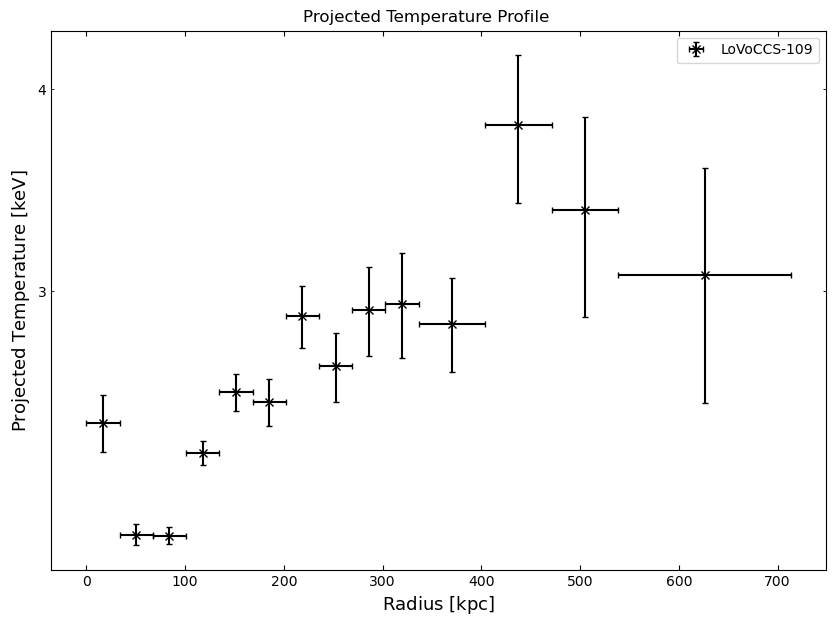

LoVoCCS-118


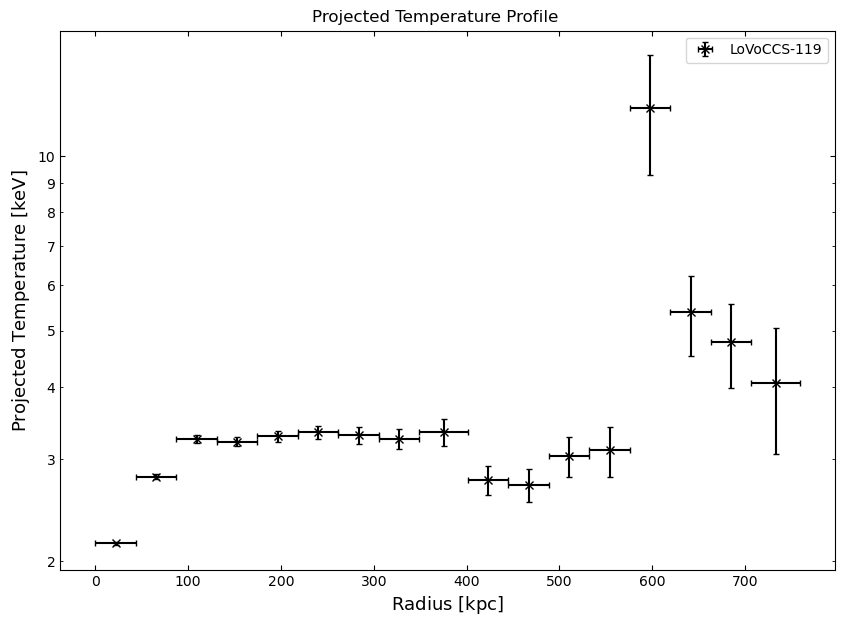

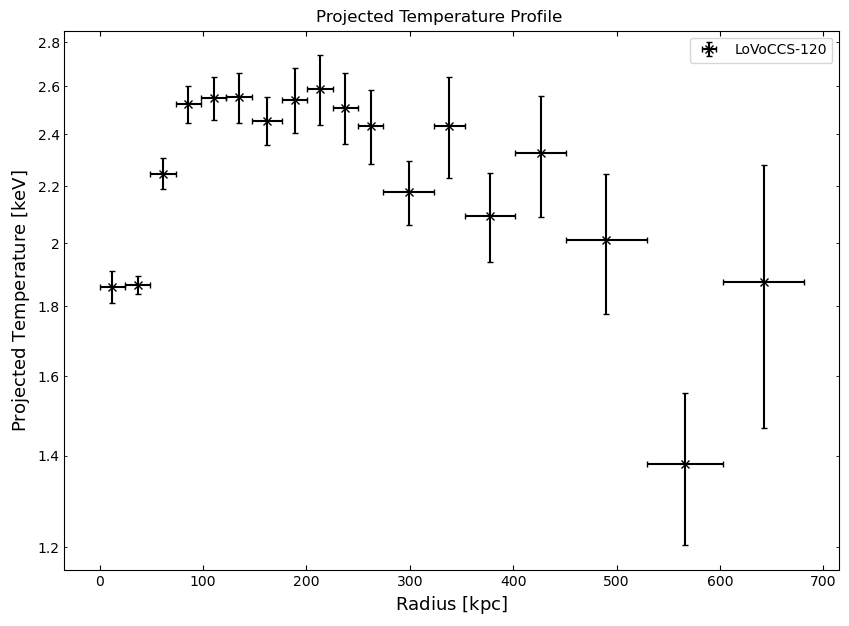

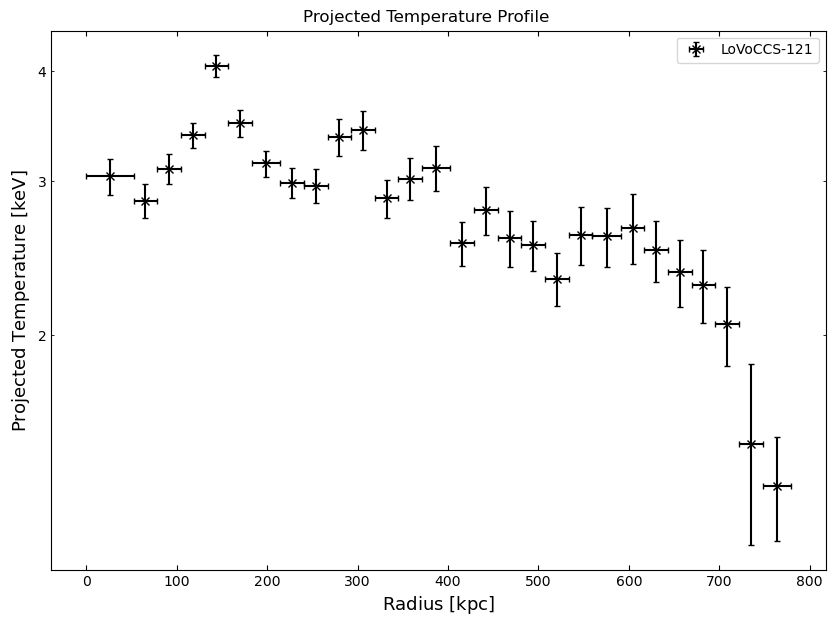

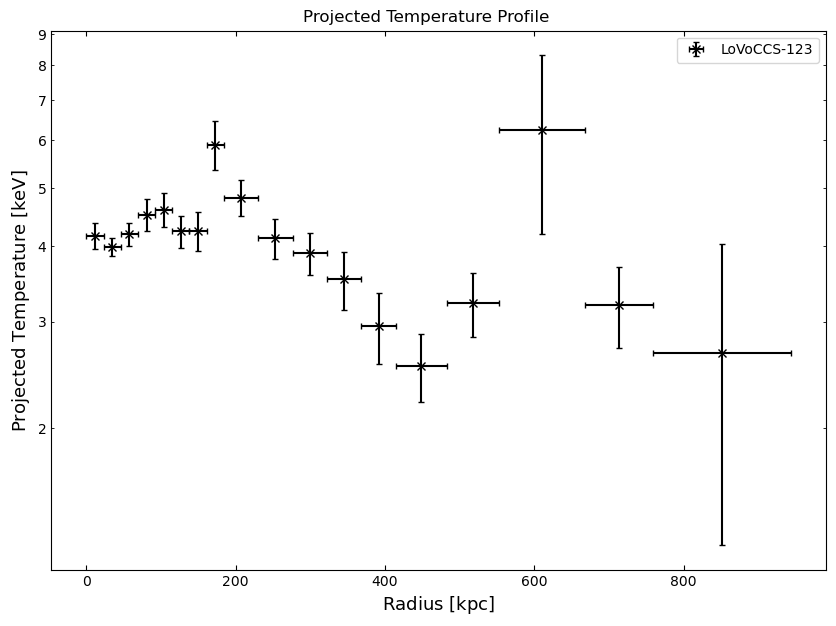

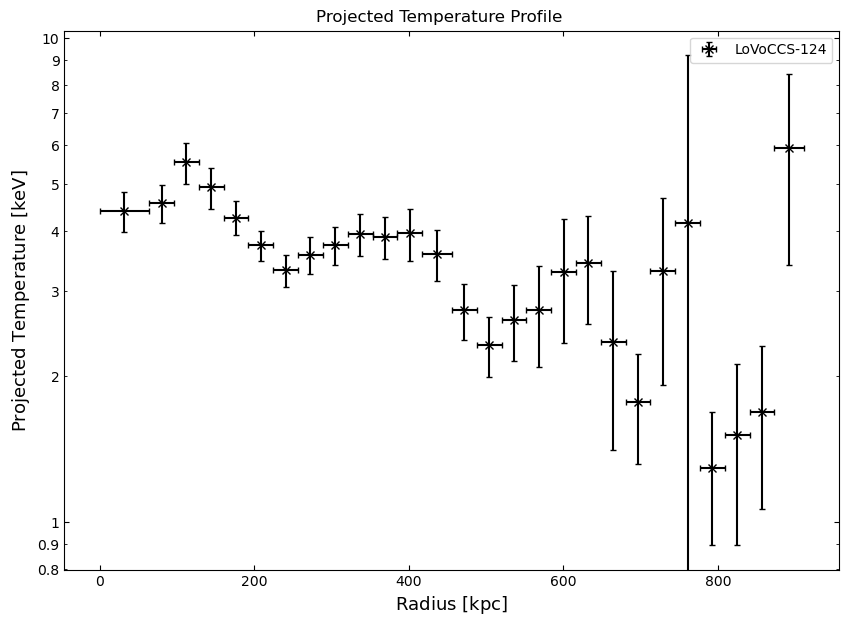

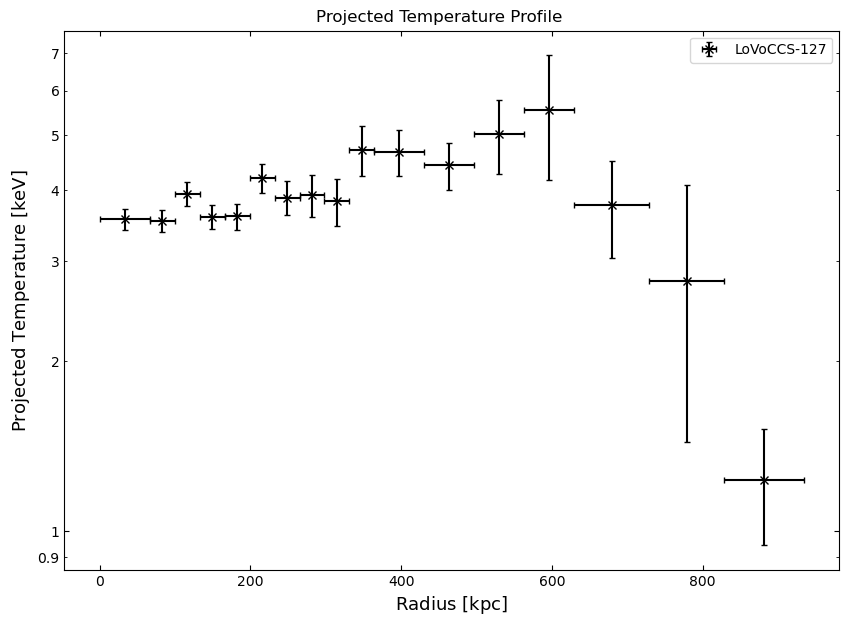

LoVoCCS-130


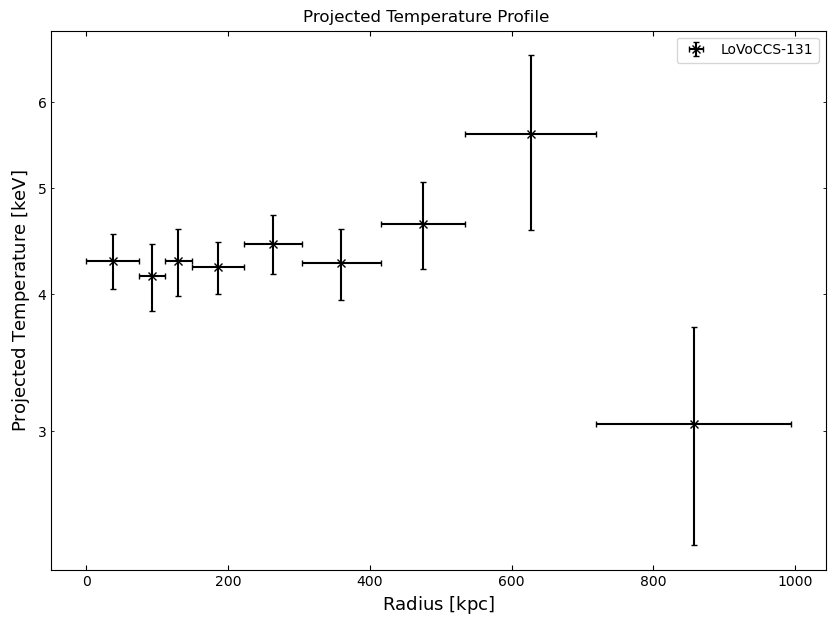

LoVoCCS-132


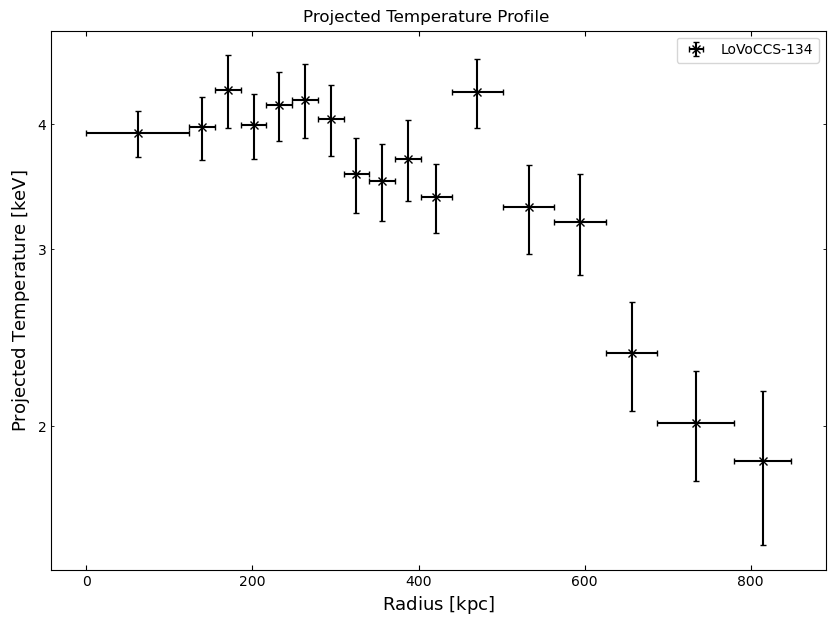

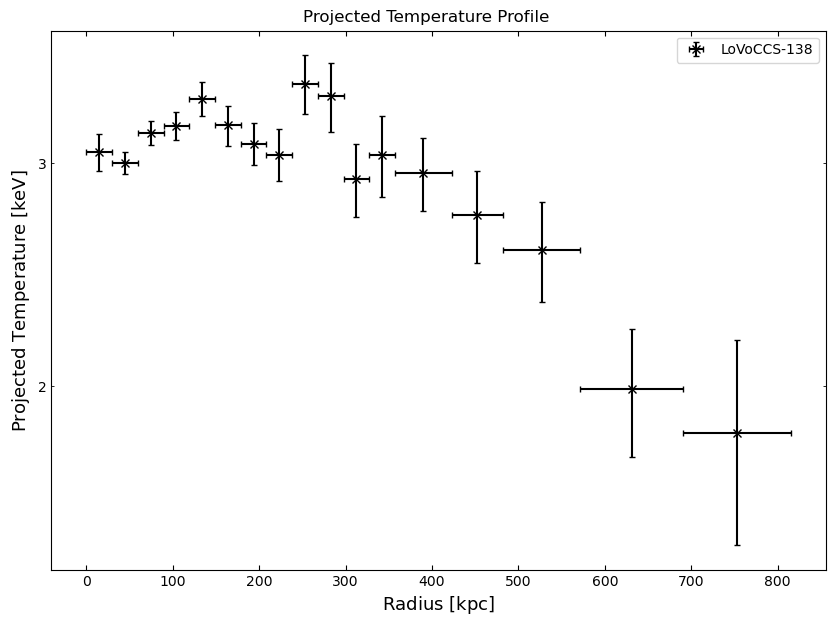

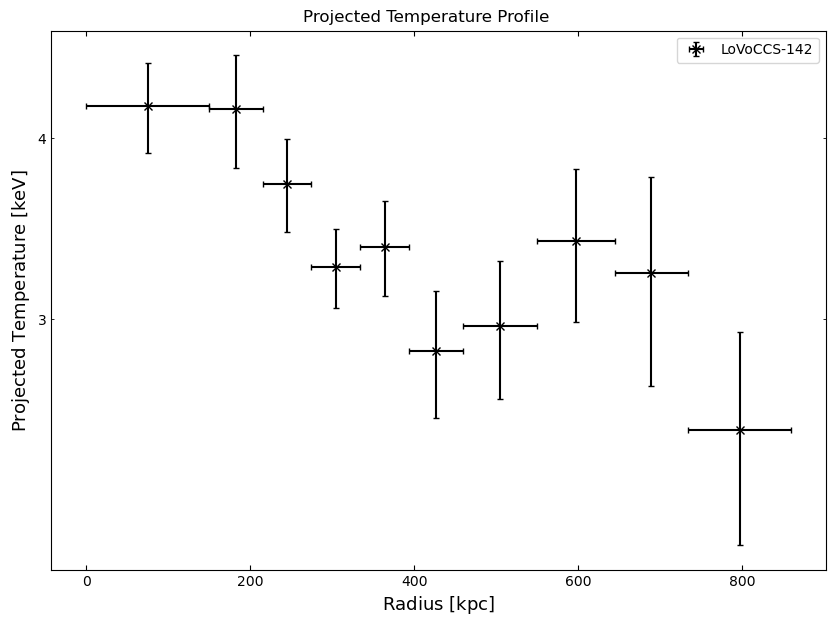

60

In [24]:
got_pt = 0
for src in srcs:
    try:
        pt = src.get_proj_temp_profiles()
        got_pt += 1
        if isinstance(pt, list):
            pt = BaseAggregateProfile1D(pt)
#         print(pt.set_ident)
        pt.view(xscale='linear')
    except NoProductAvailableError:
        print(src.name)
got_pt

LoVoCCS-0


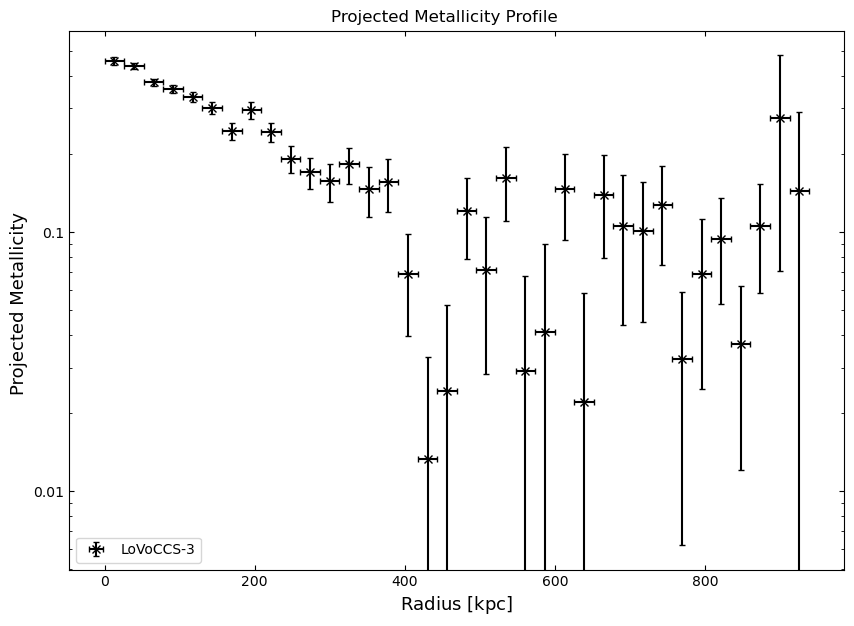

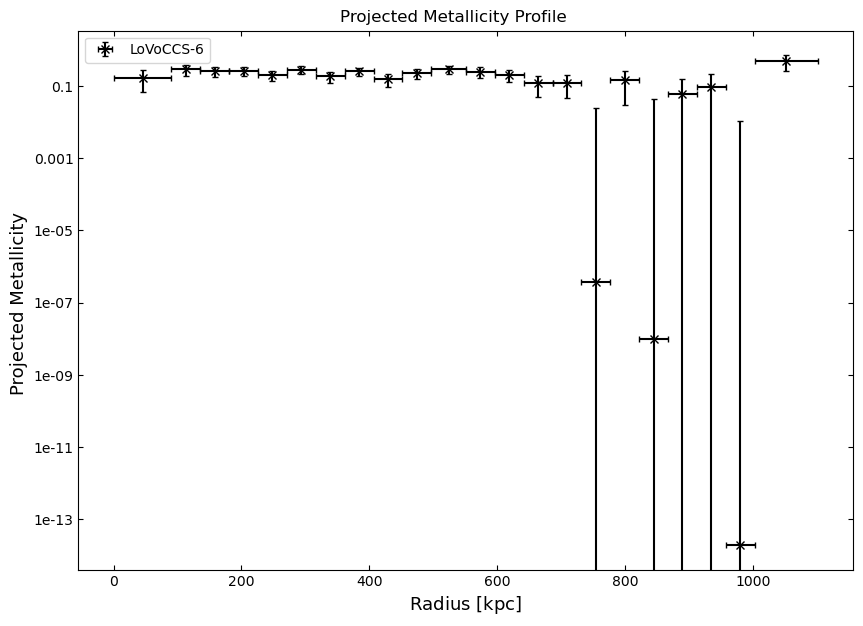

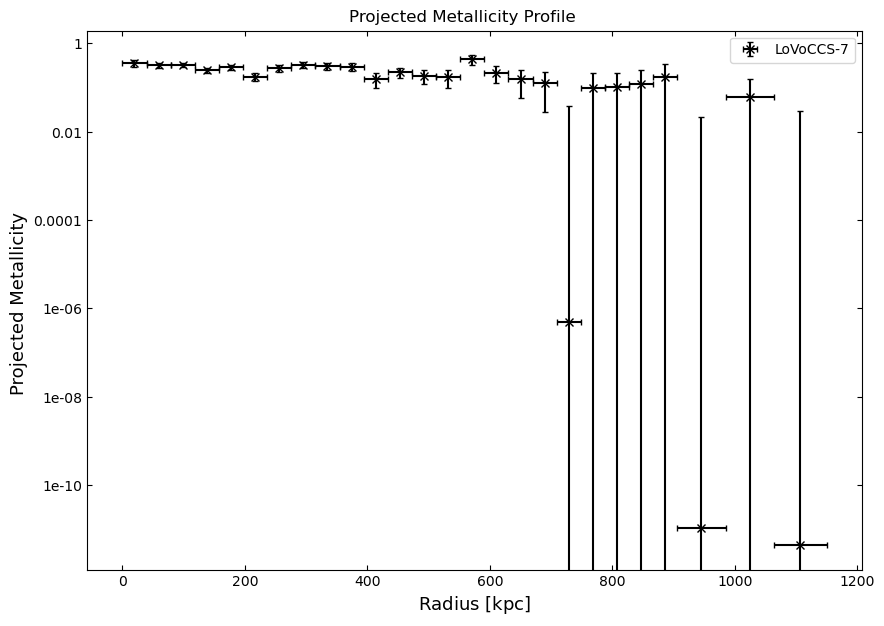

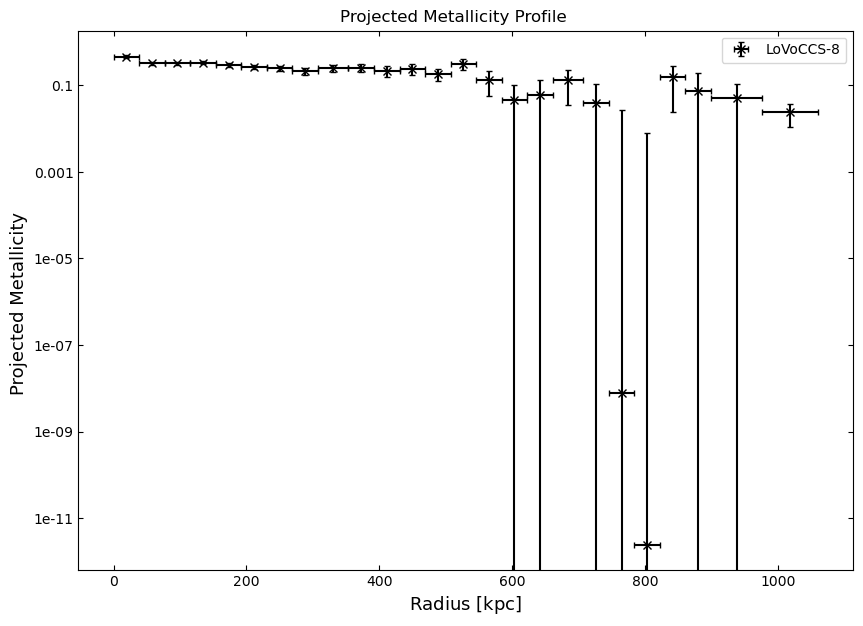

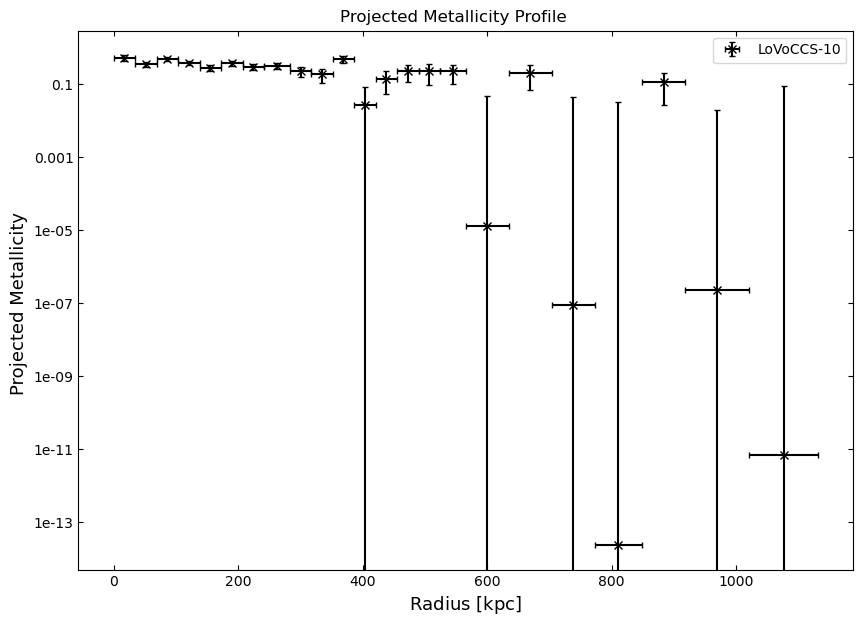

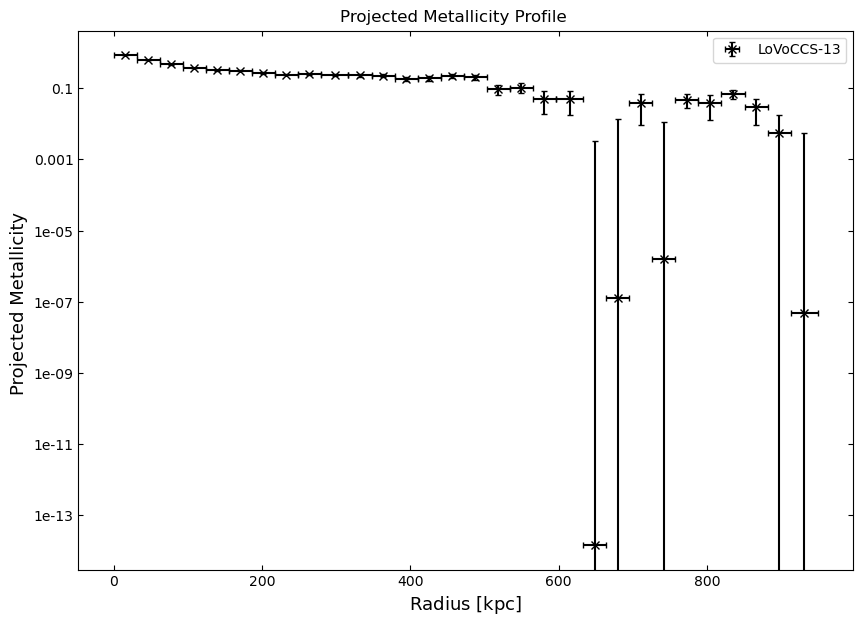

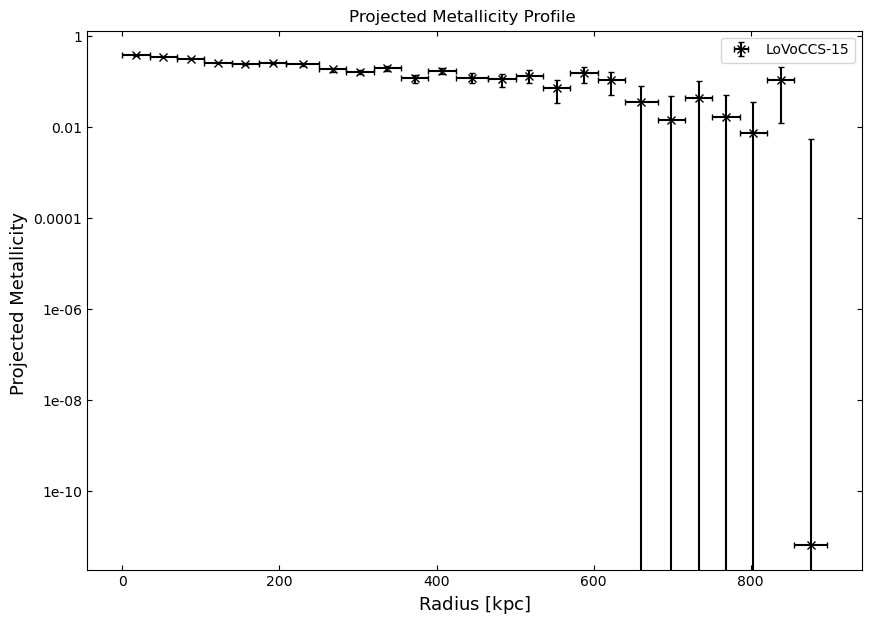

LoVoCCS-17


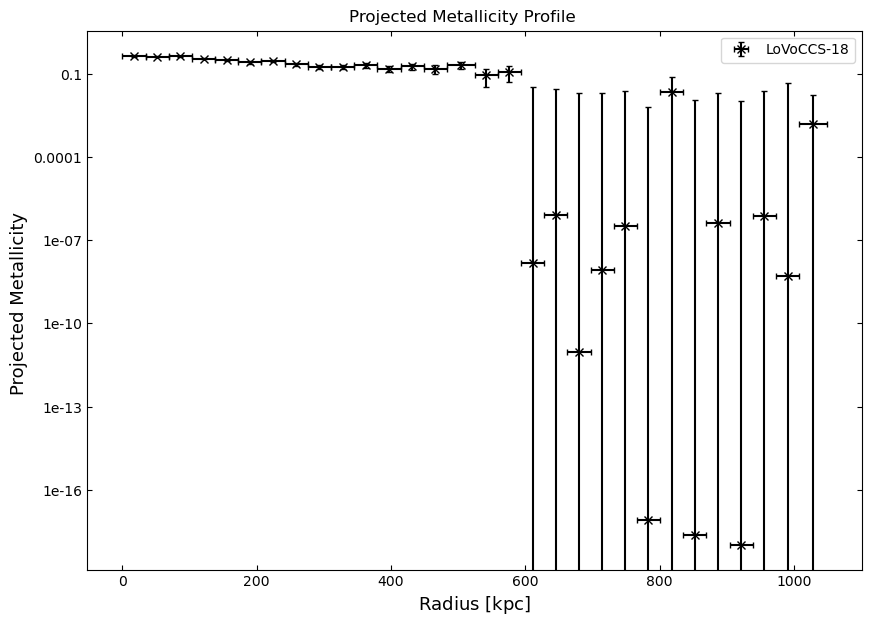

LoVoCCS-20
LoVoCCS-22


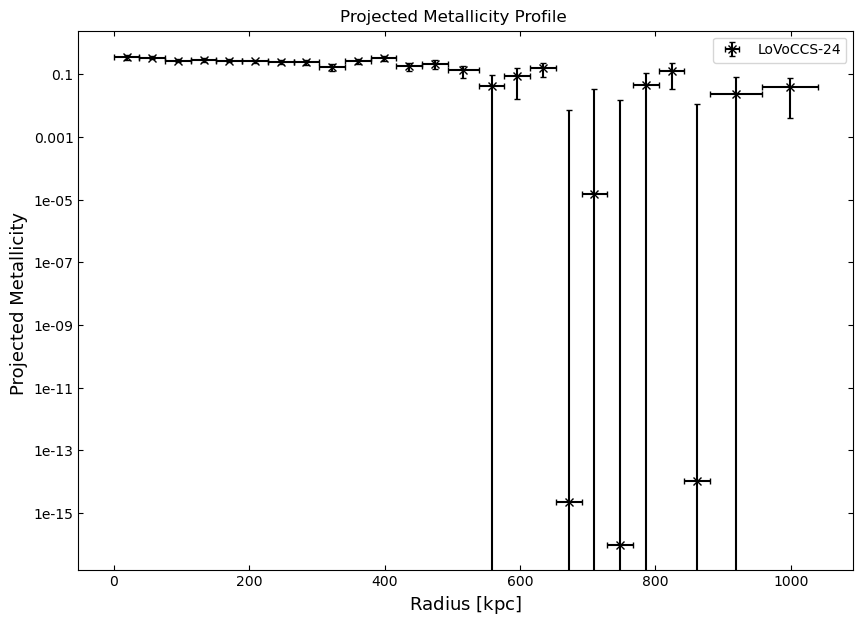

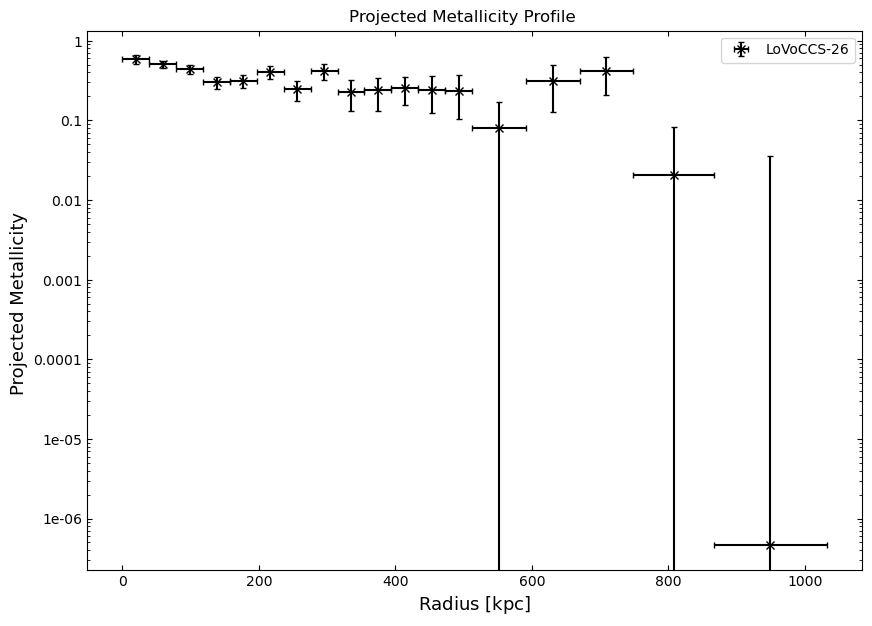

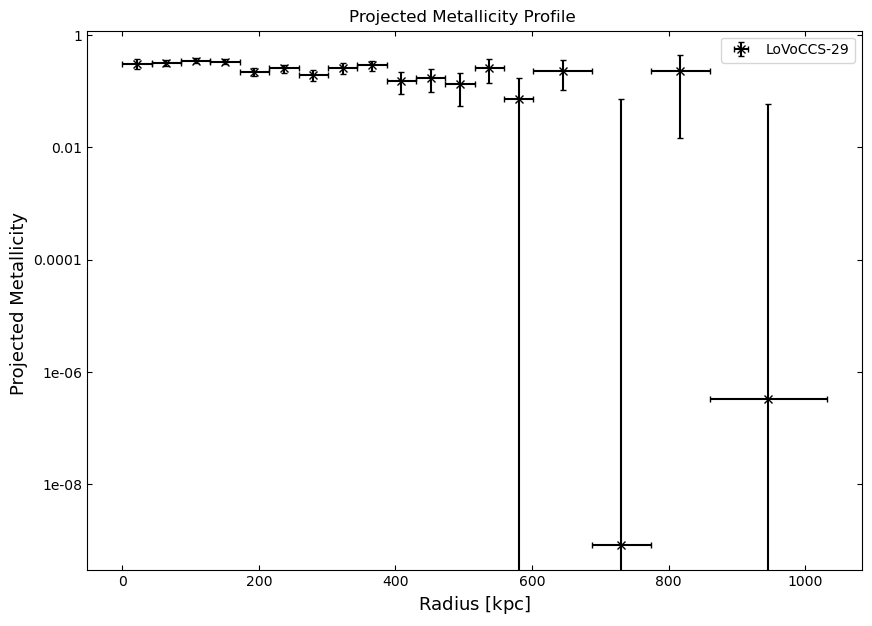

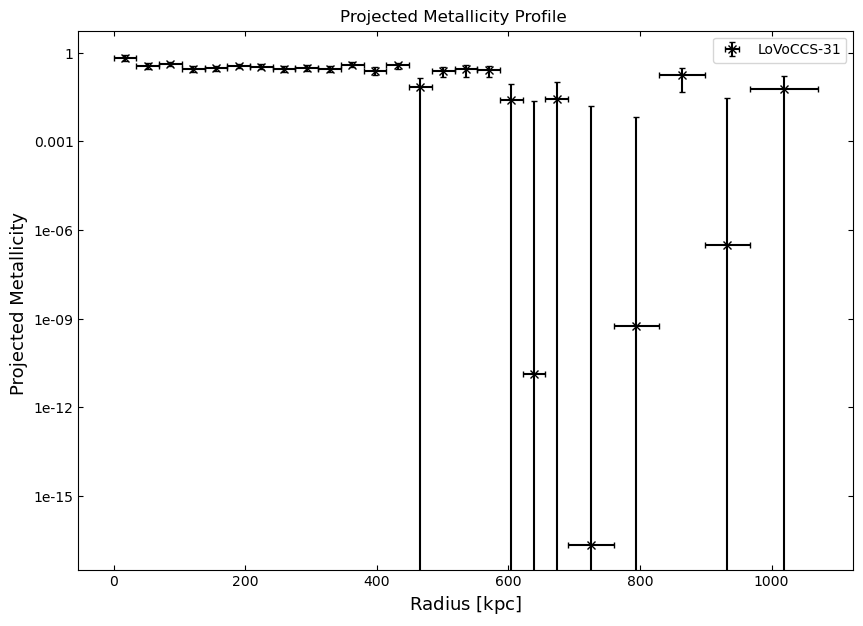

LoVoCCS-32


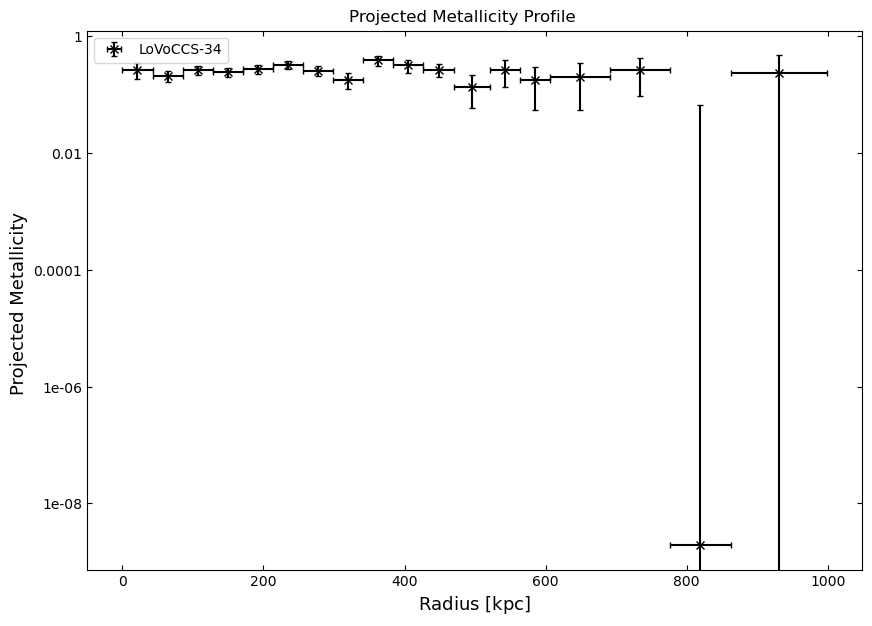

LoVoCCS-35


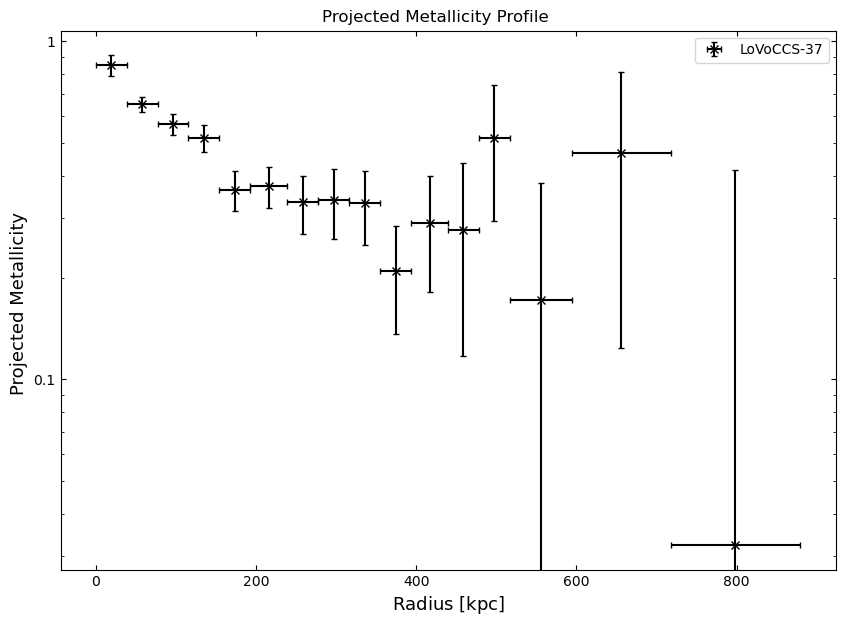

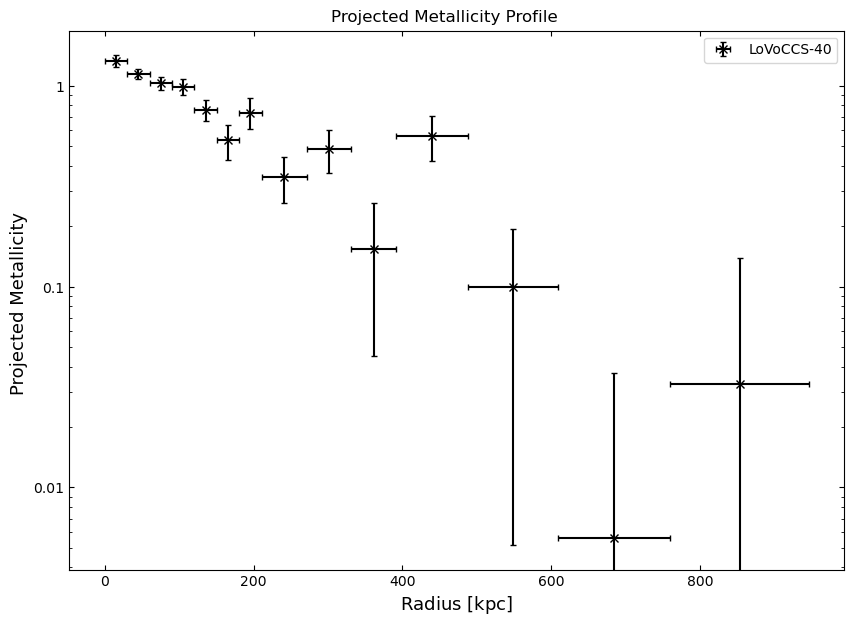

LoVoCCS-41


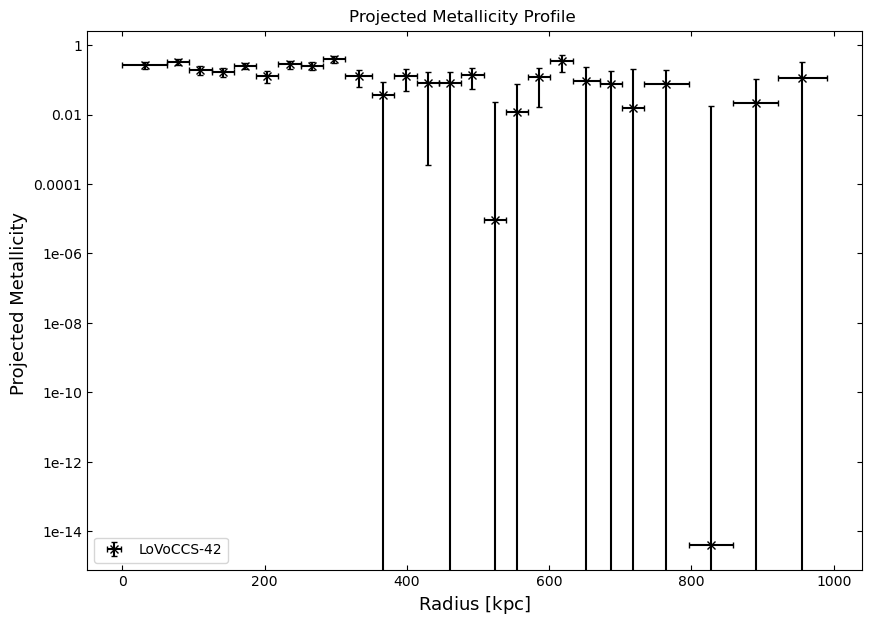

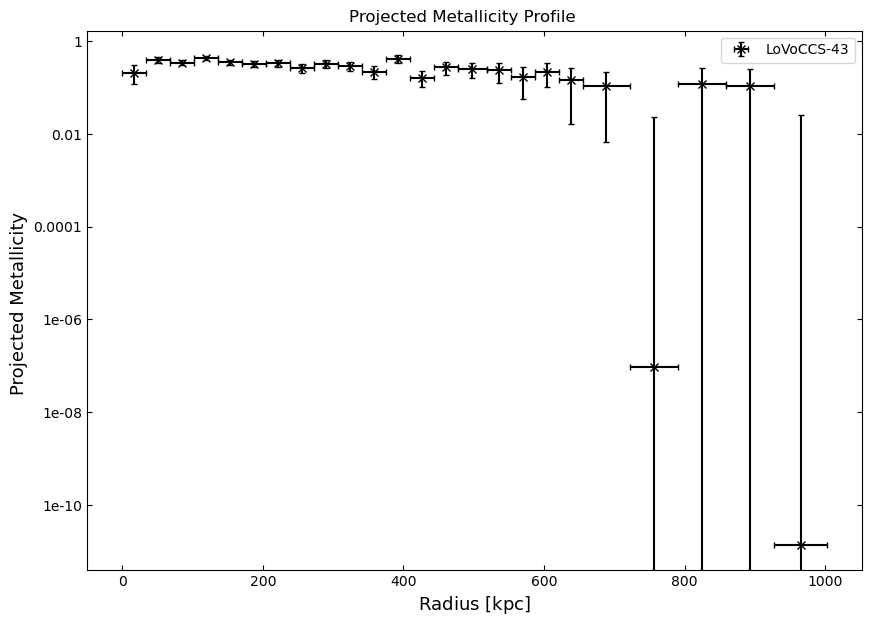

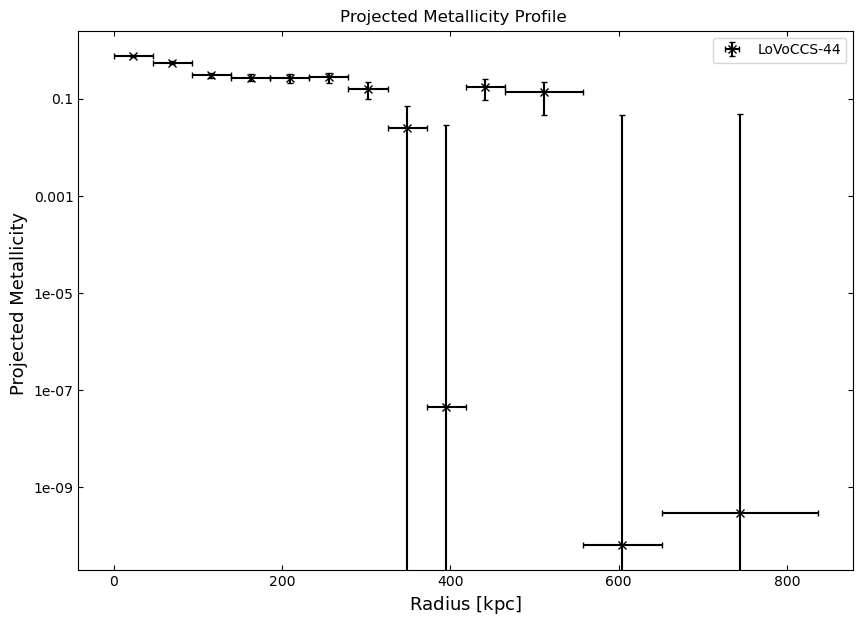

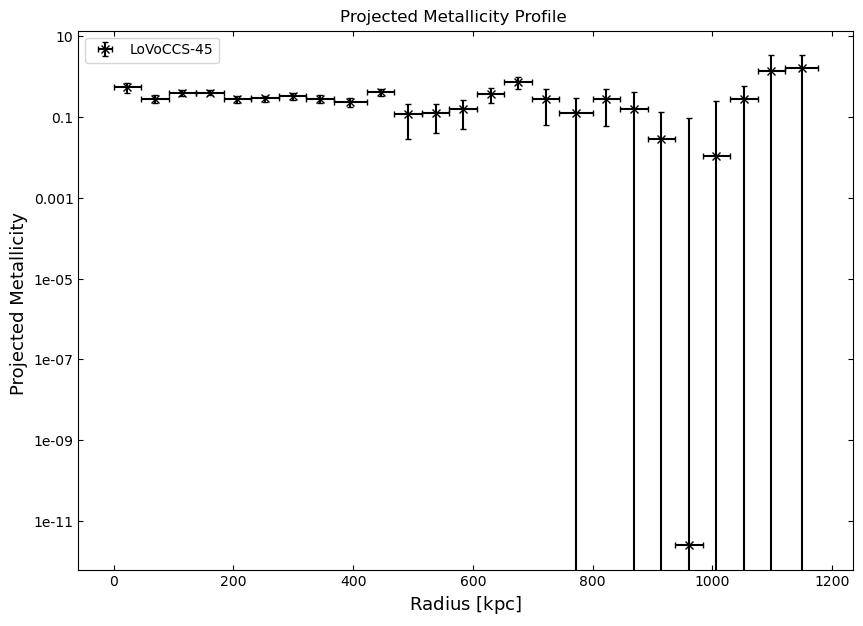

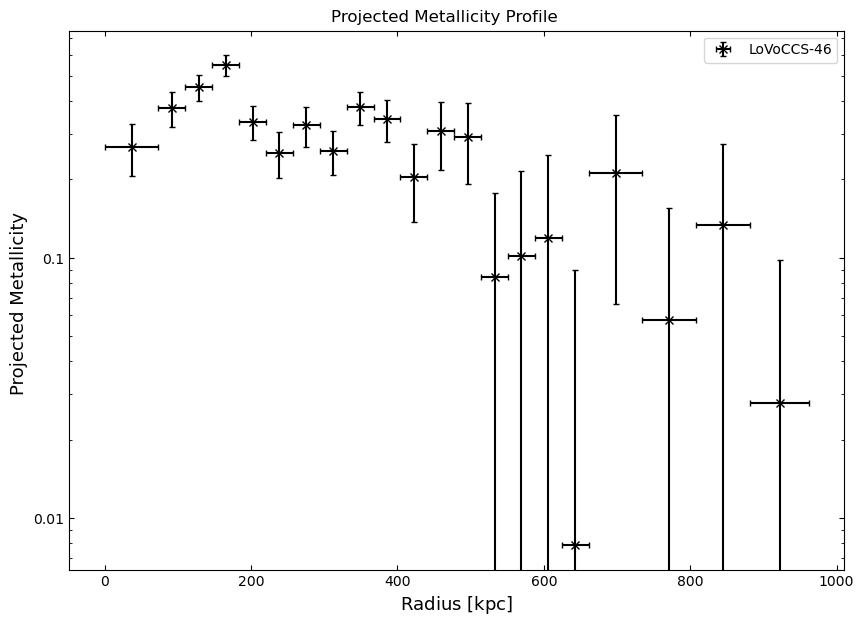

LoVoCCS-48


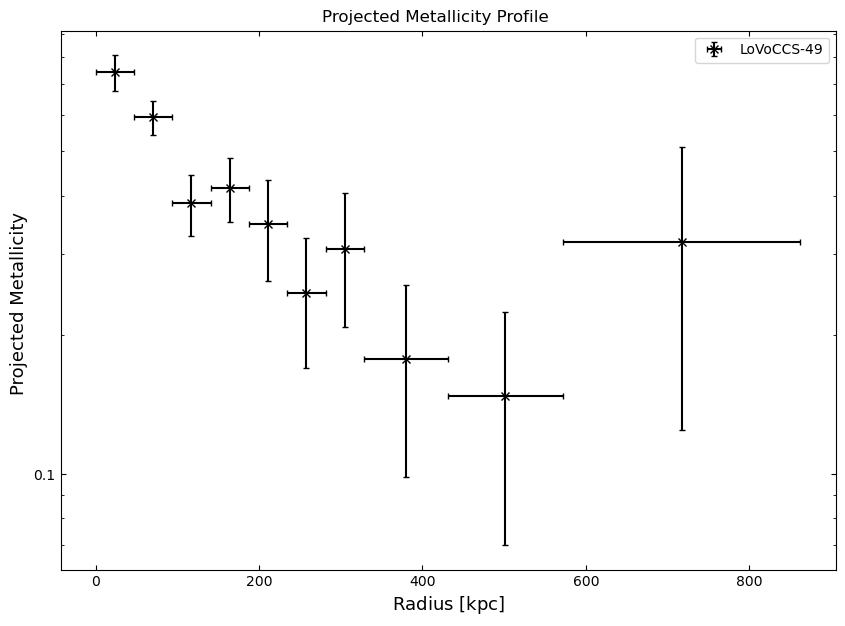

LoVoCCS-50
LoVoCCS-51


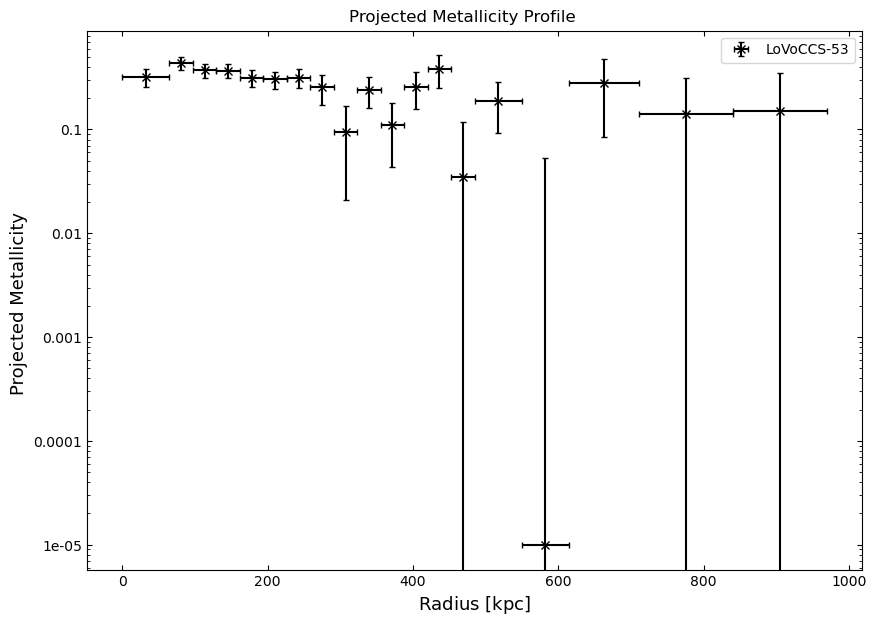

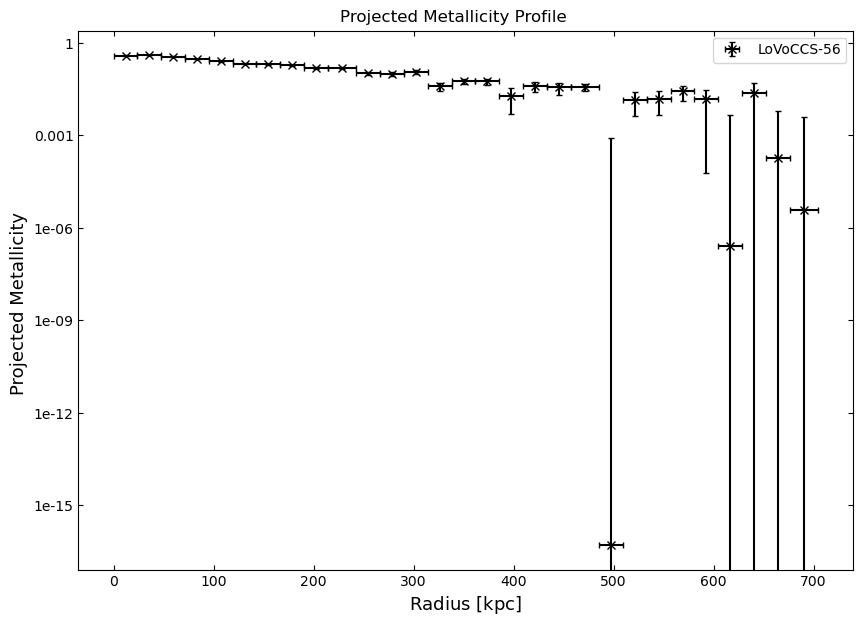

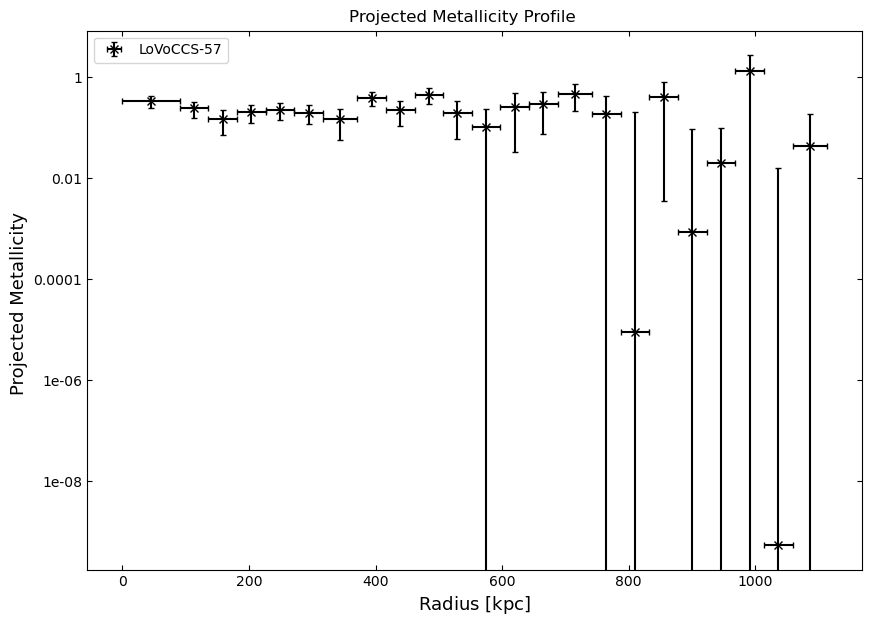

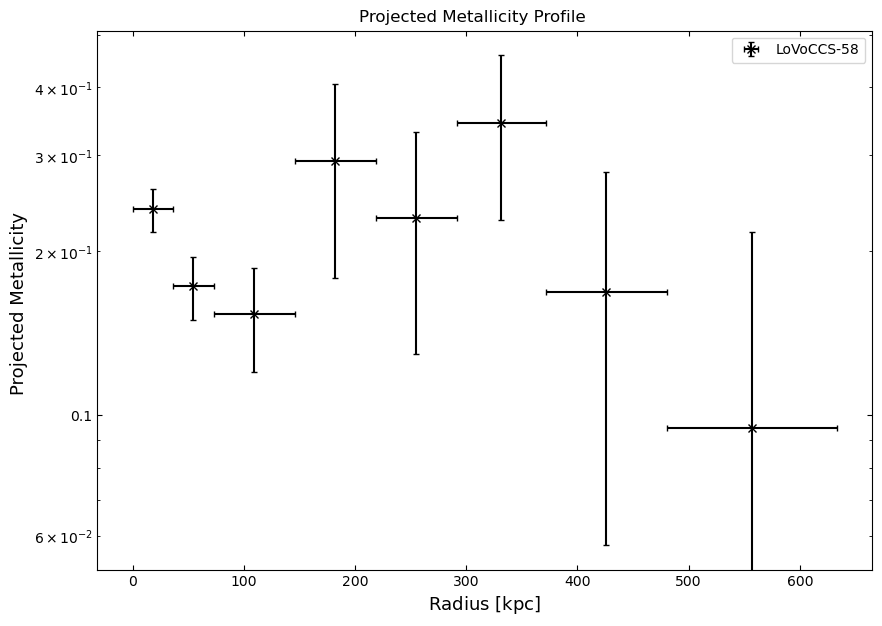

LoVoCCS-59


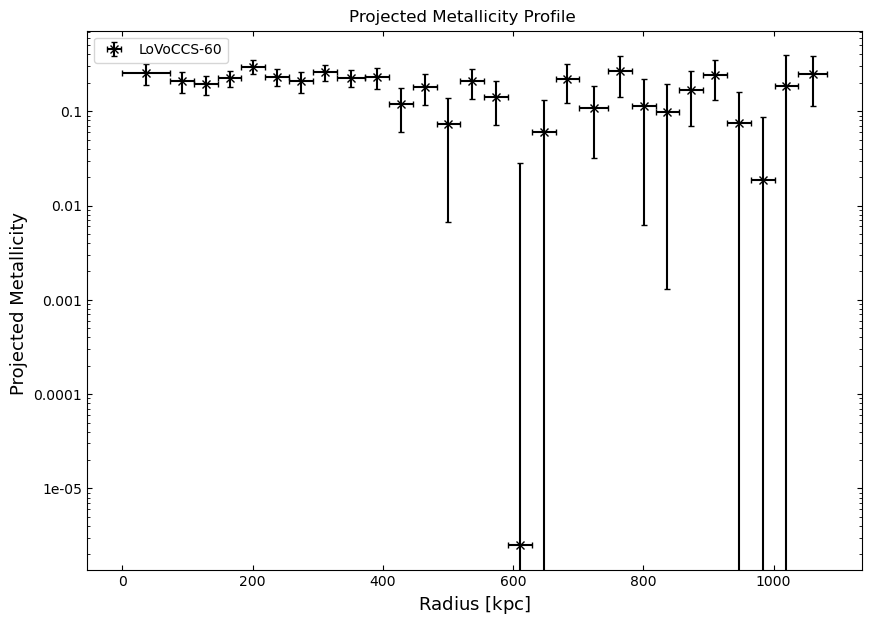

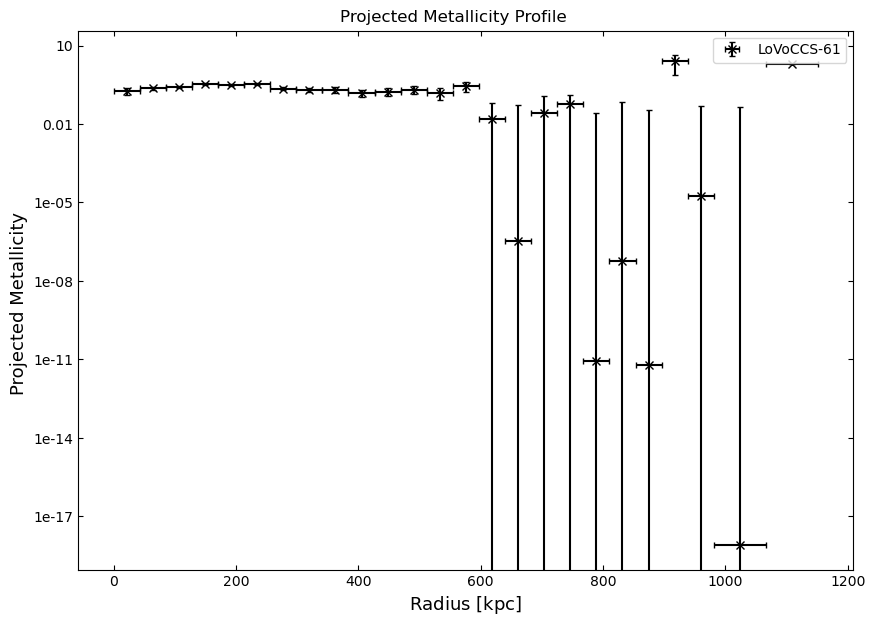

LoVoCCS-63


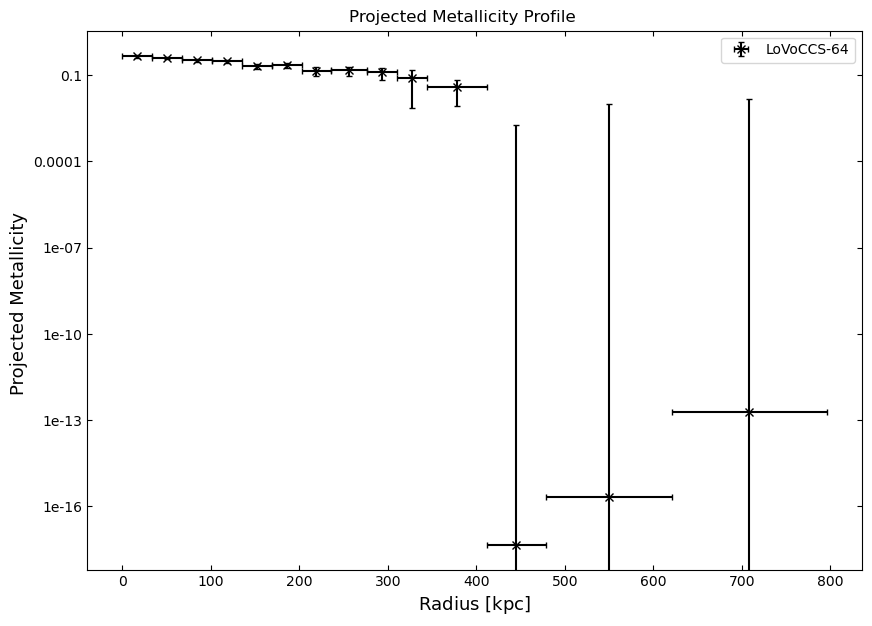

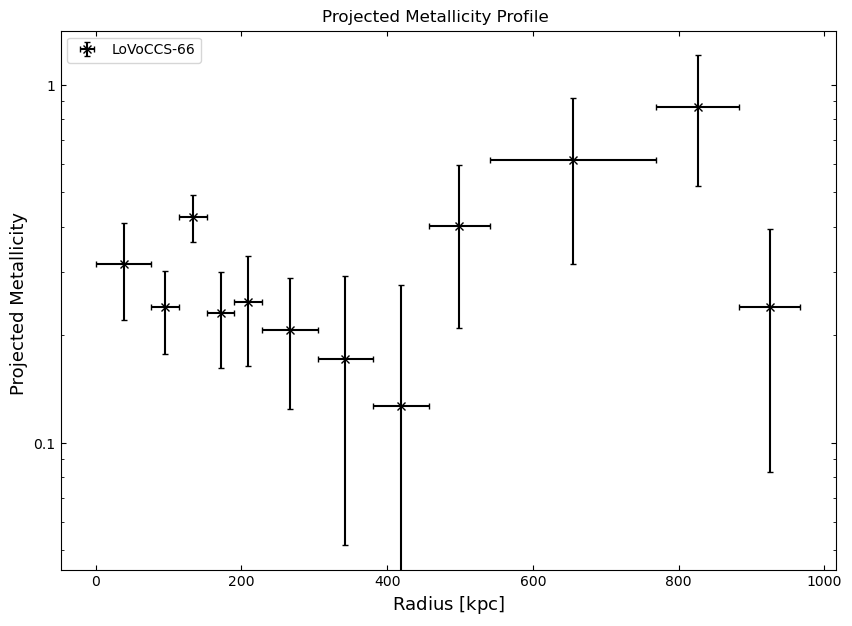

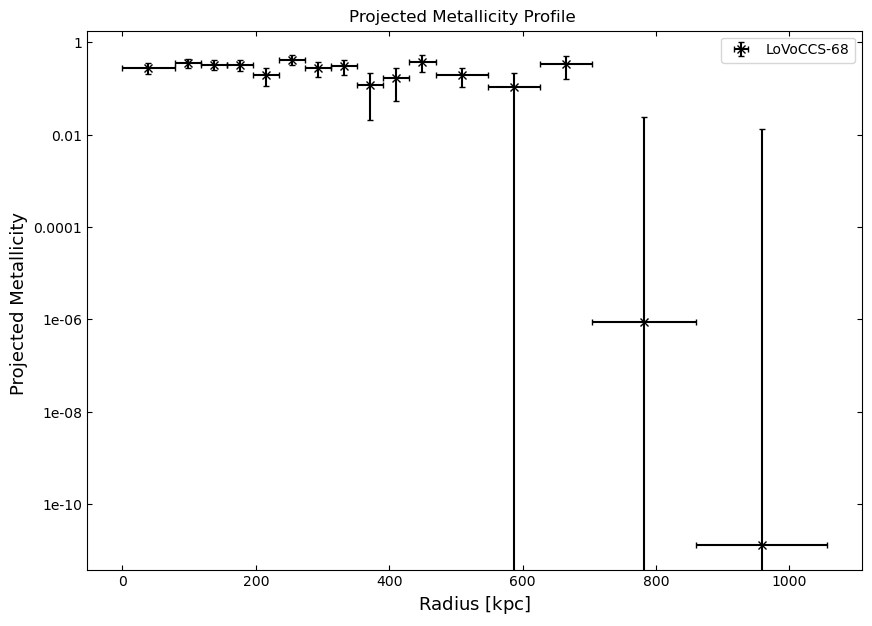

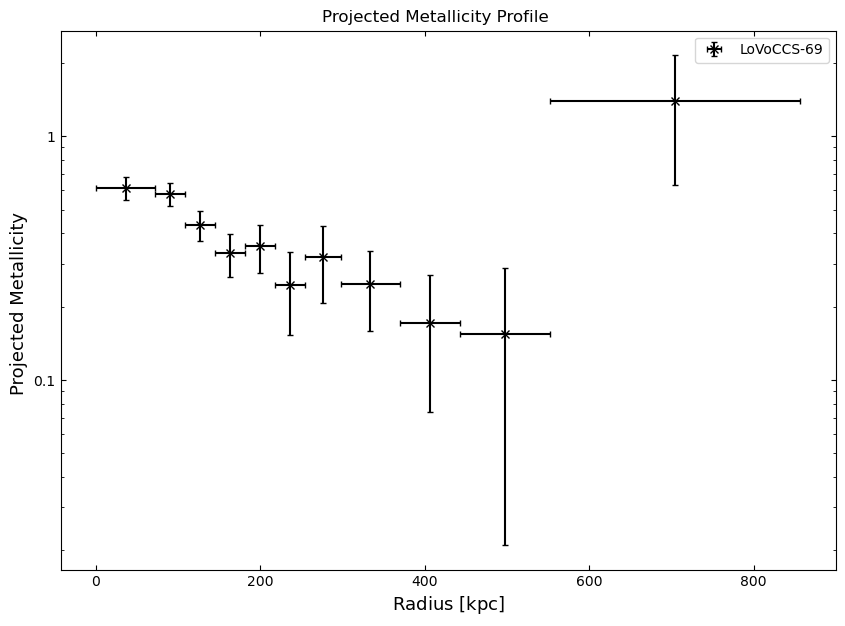

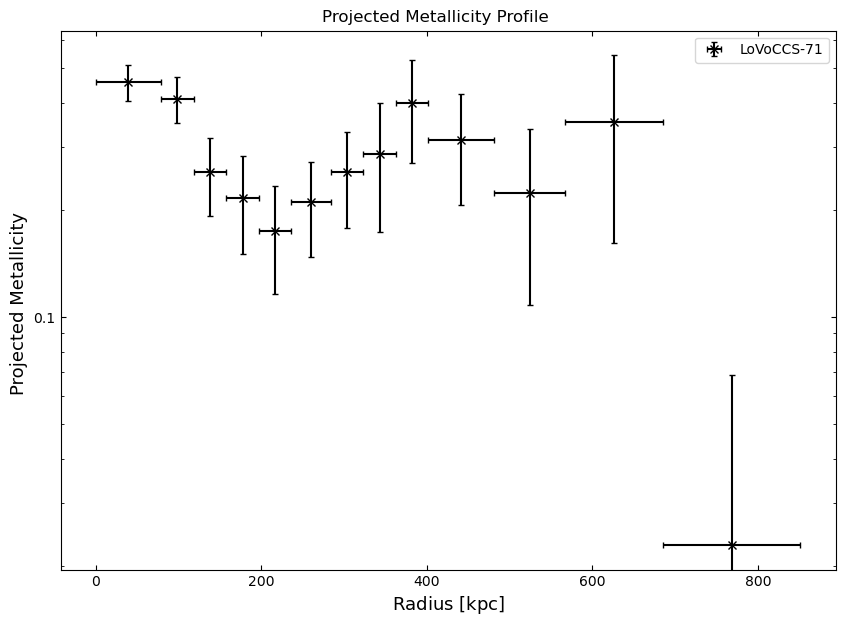

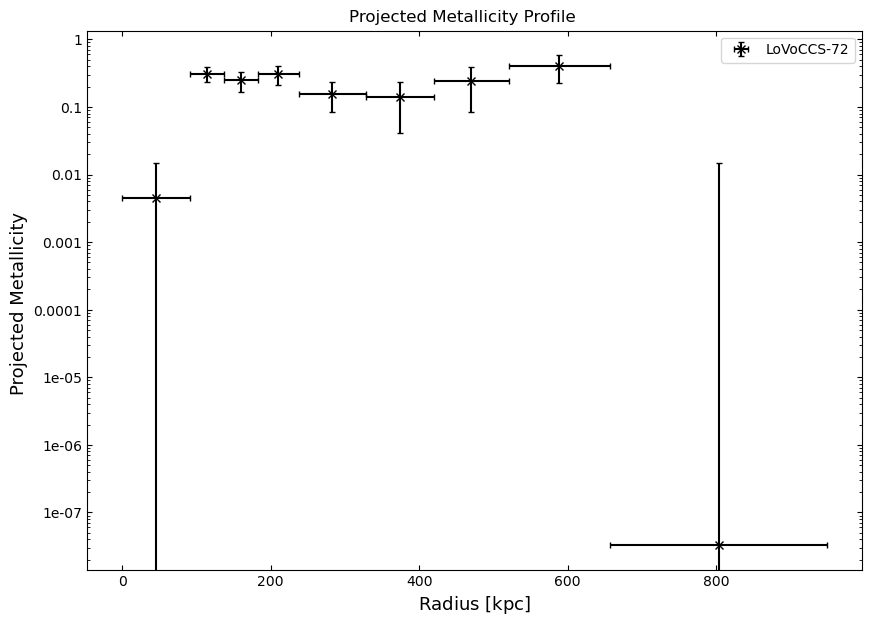

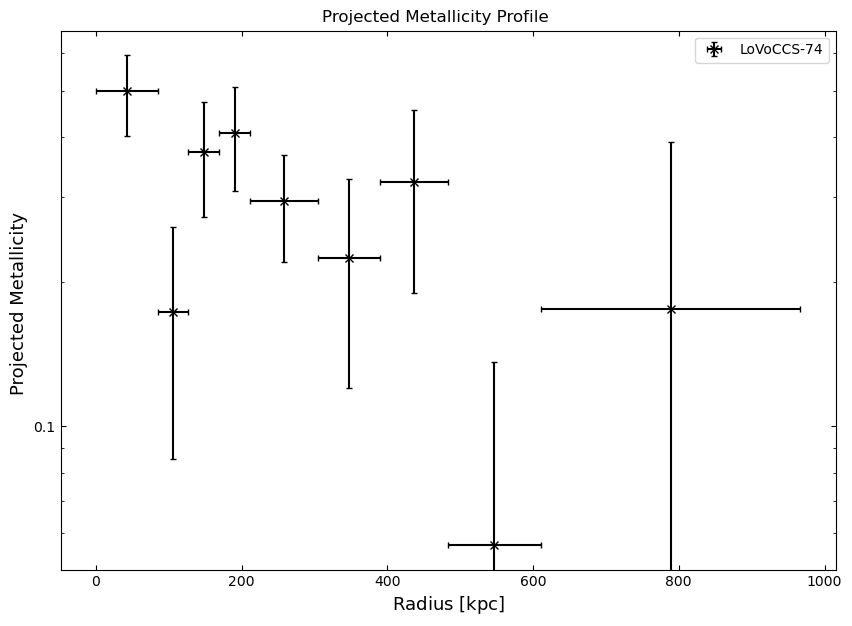

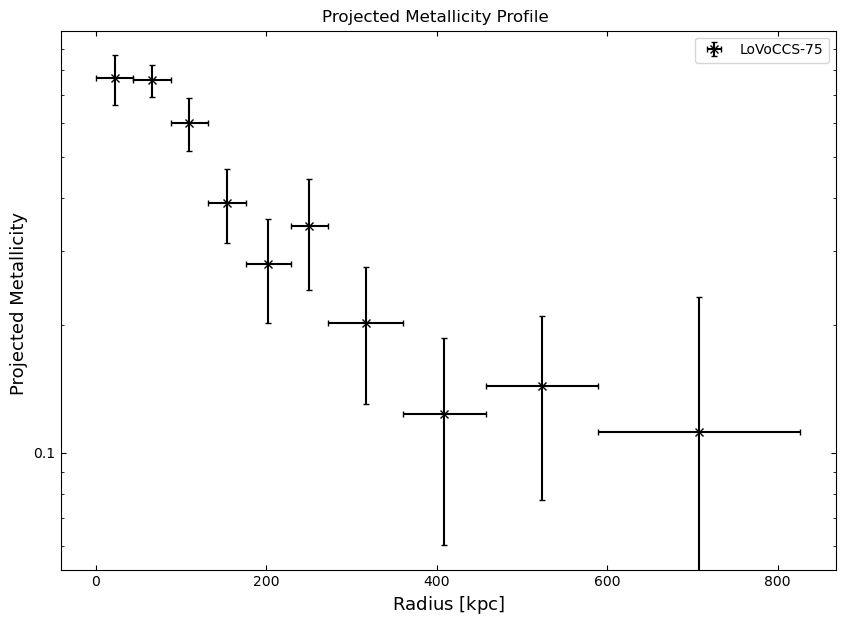

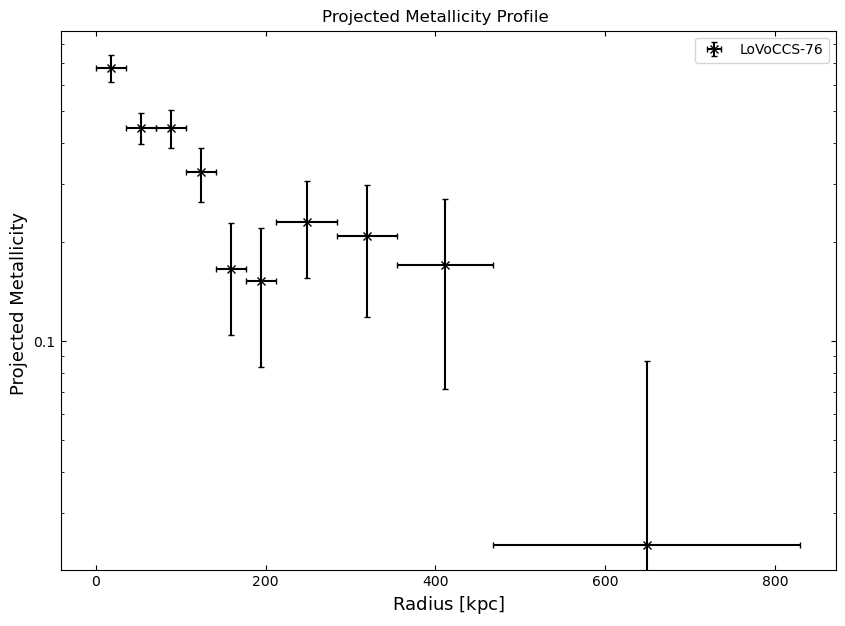

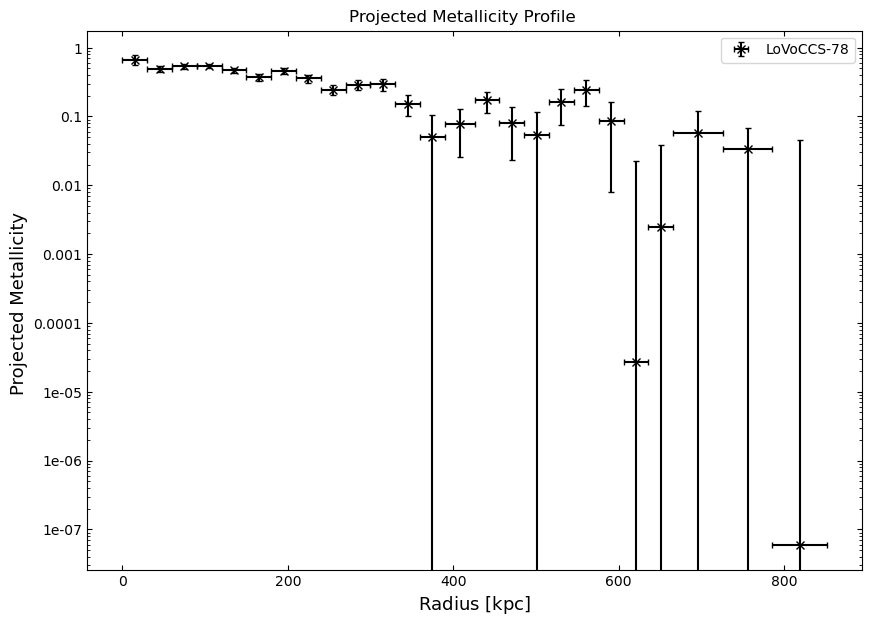

LoVoCCS-80


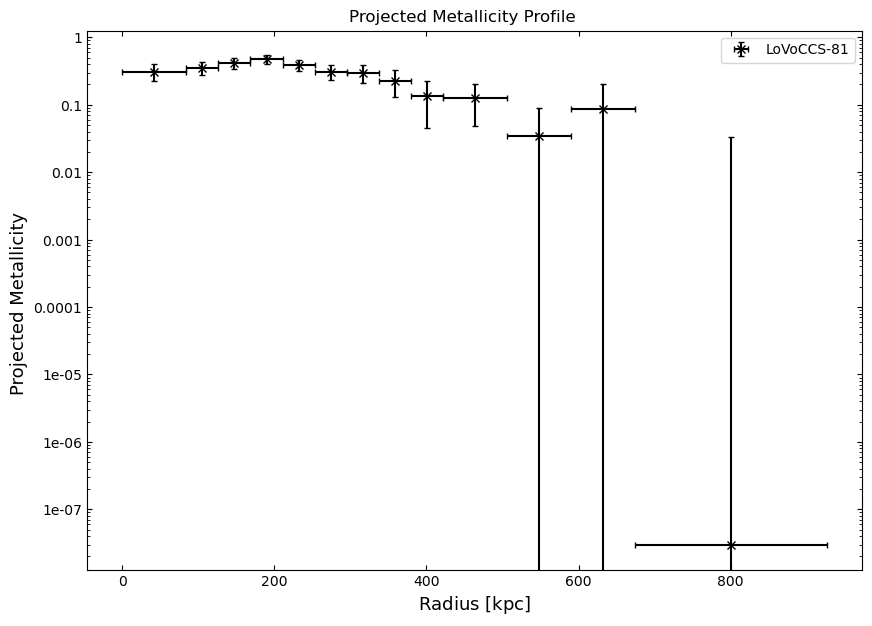

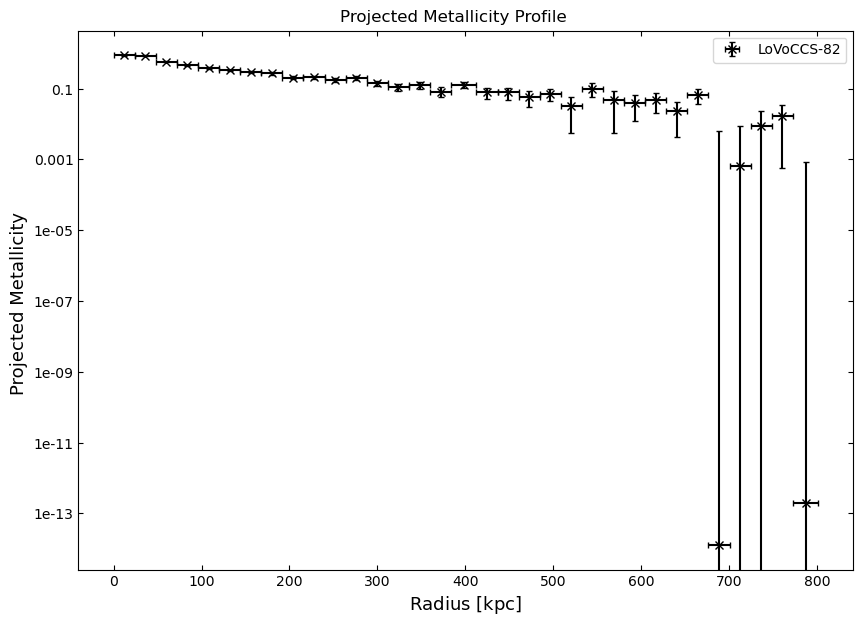

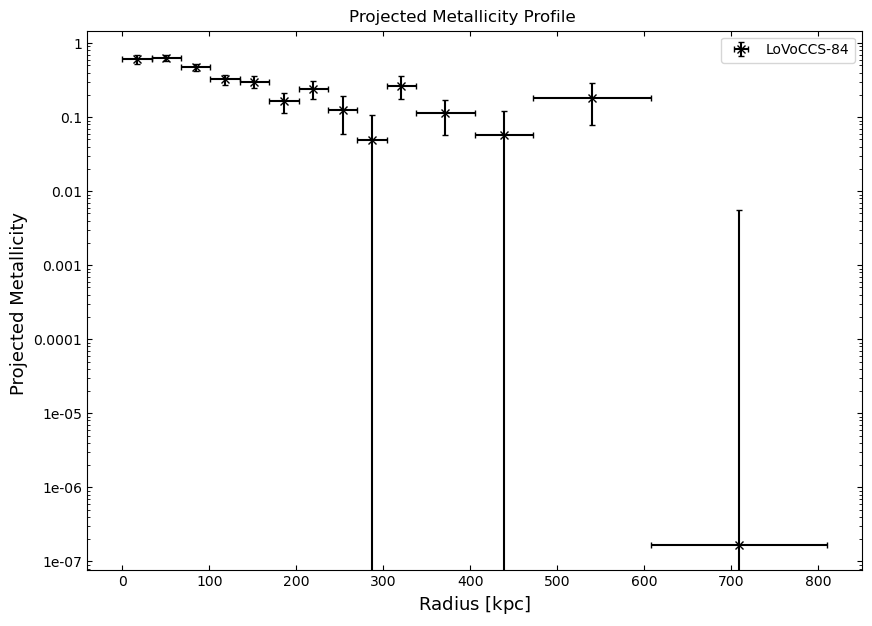

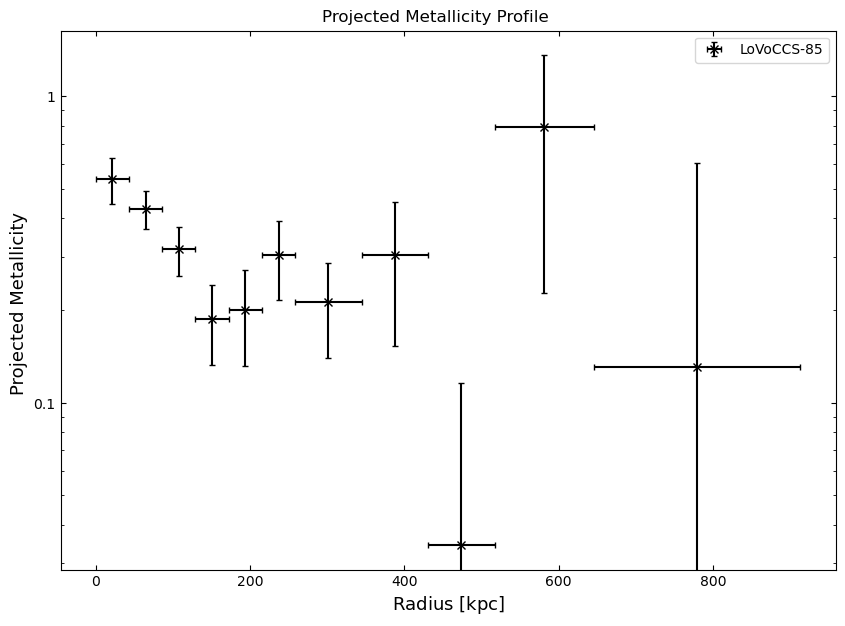

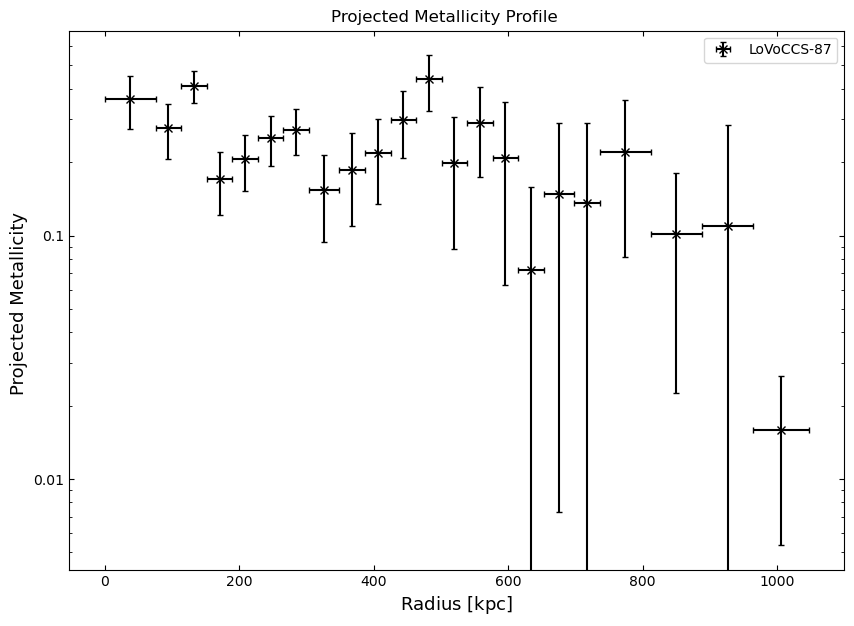

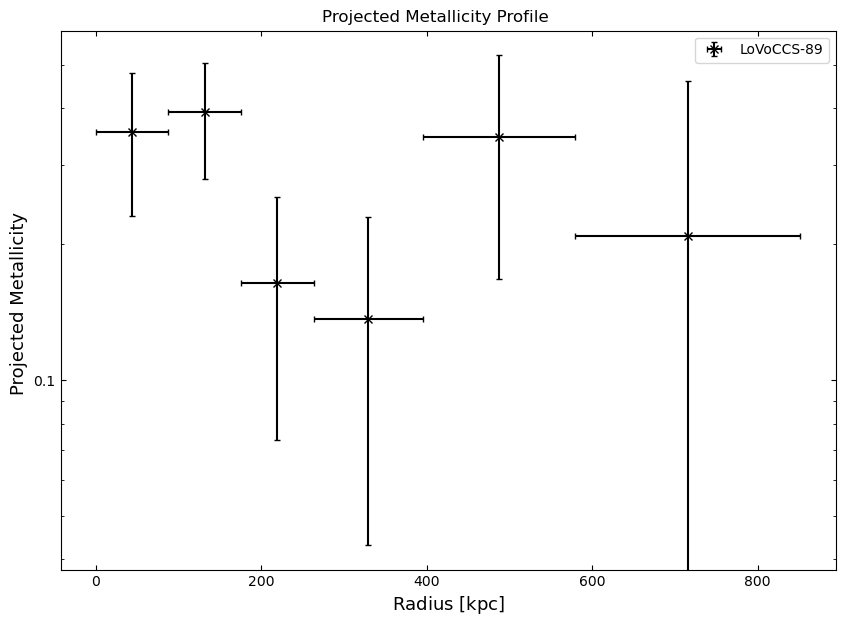

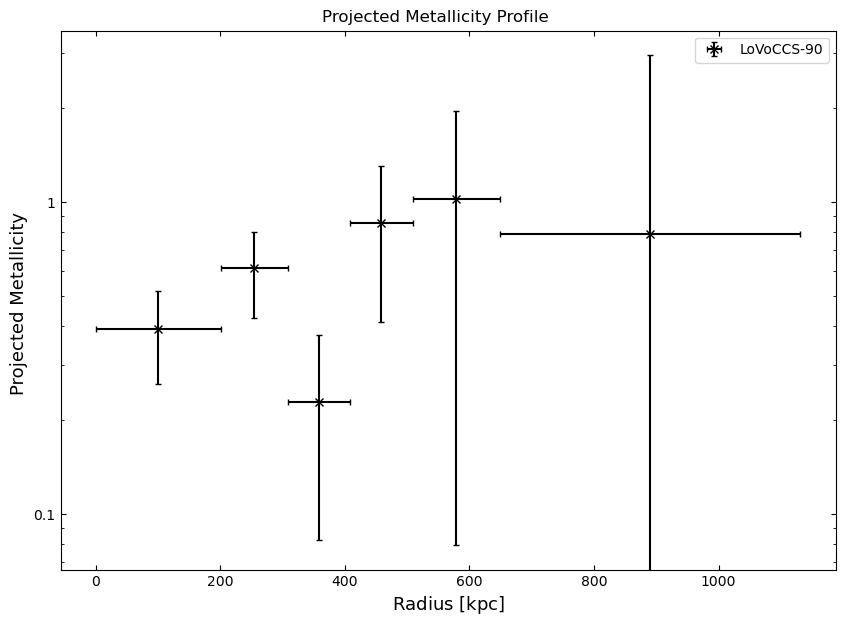

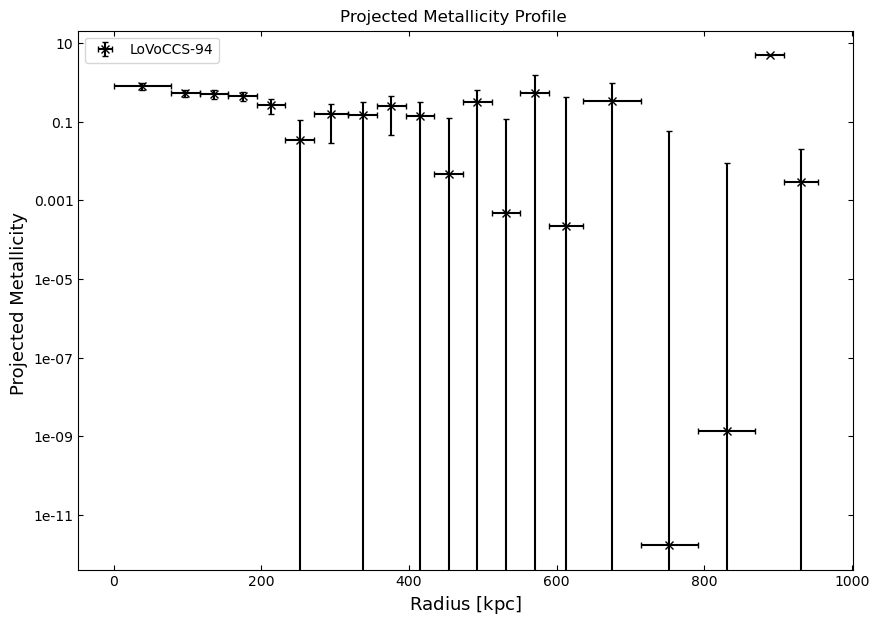

LoVoCCS-95
LoVoCCS-96


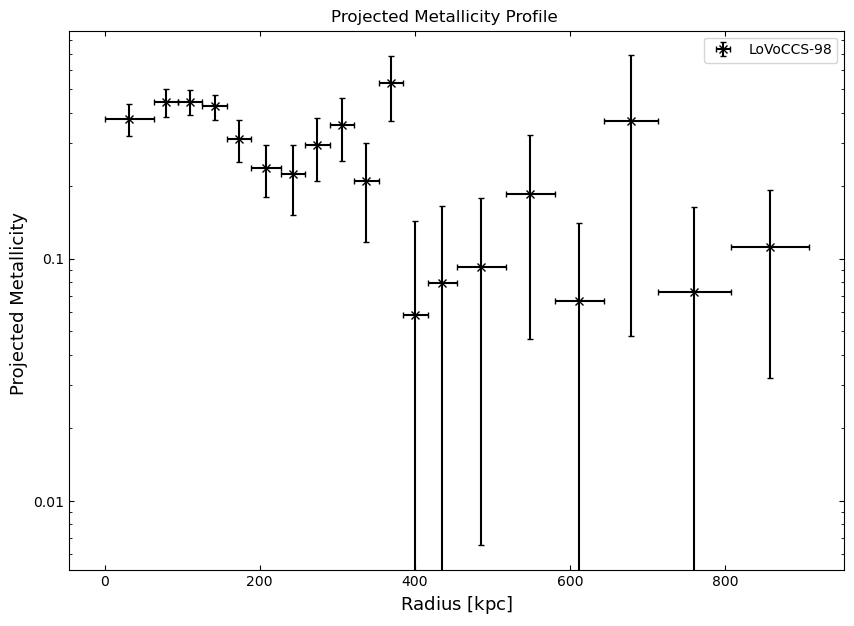

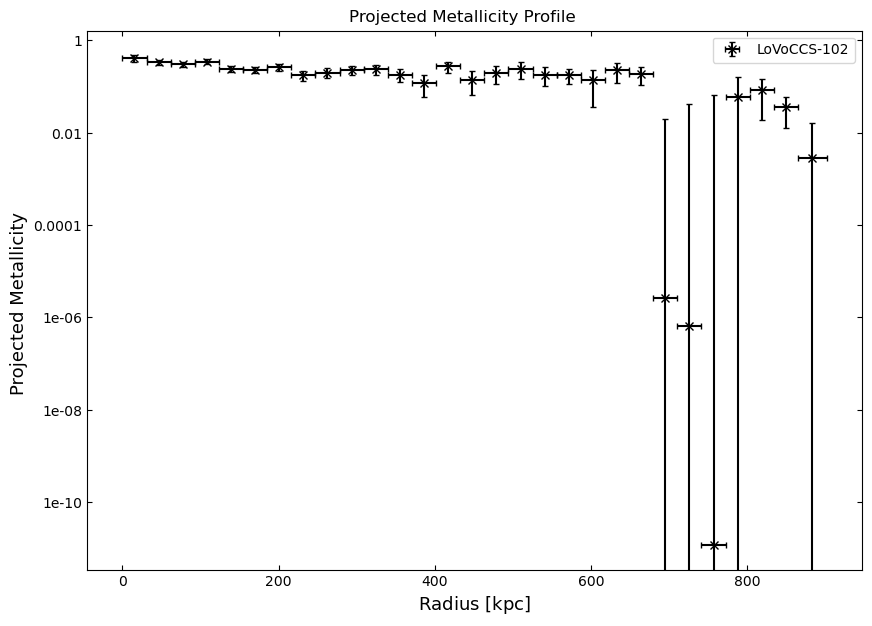

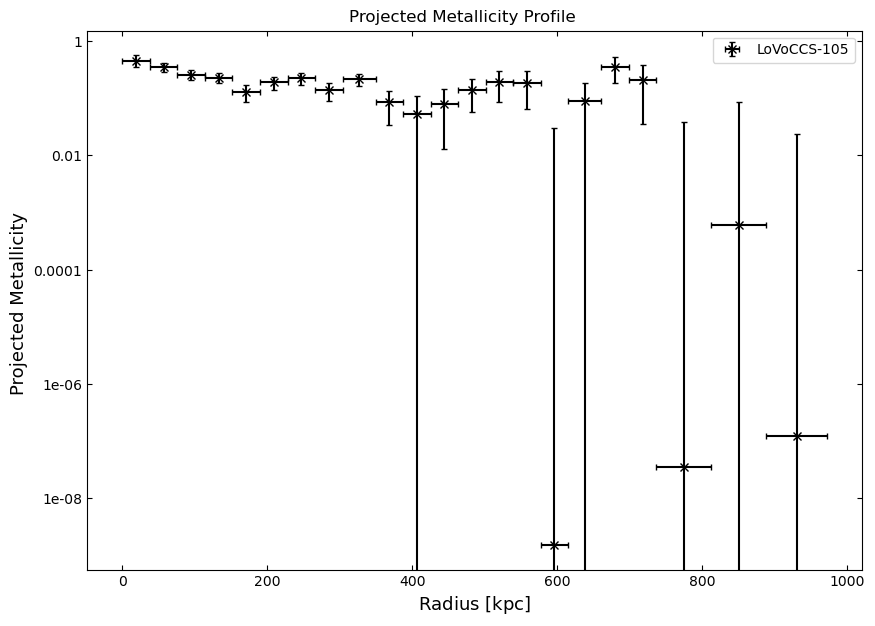

LoVoCCS-106


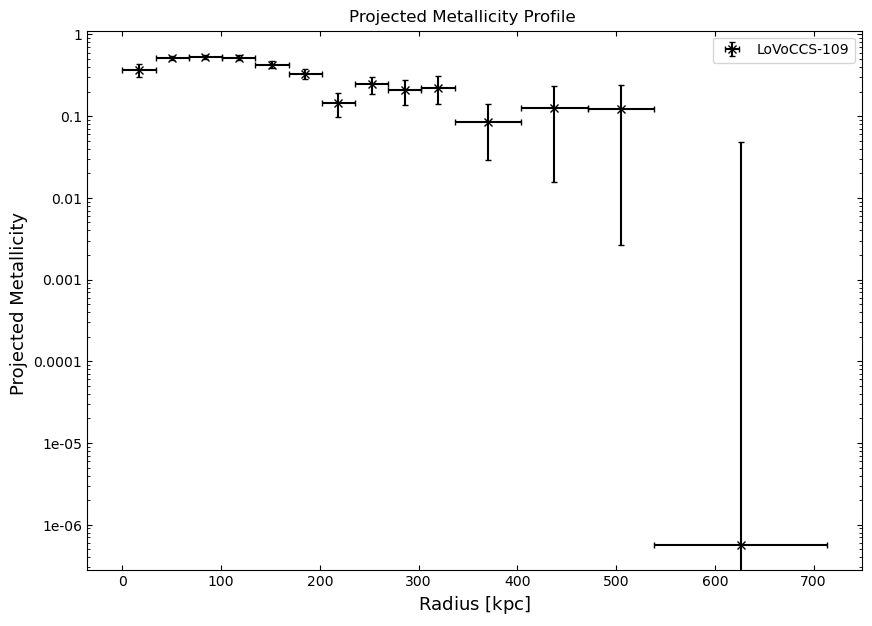

LoVoCCS-118


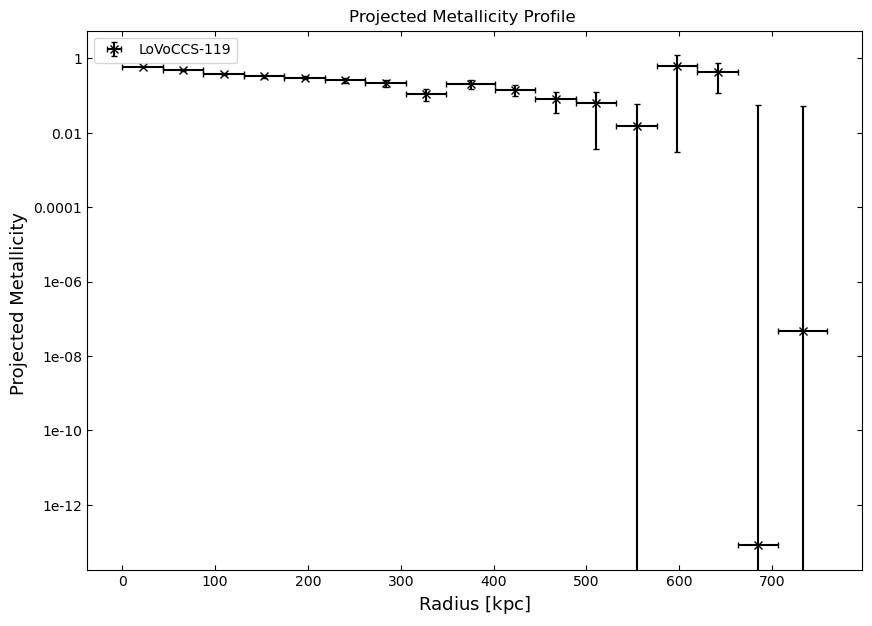

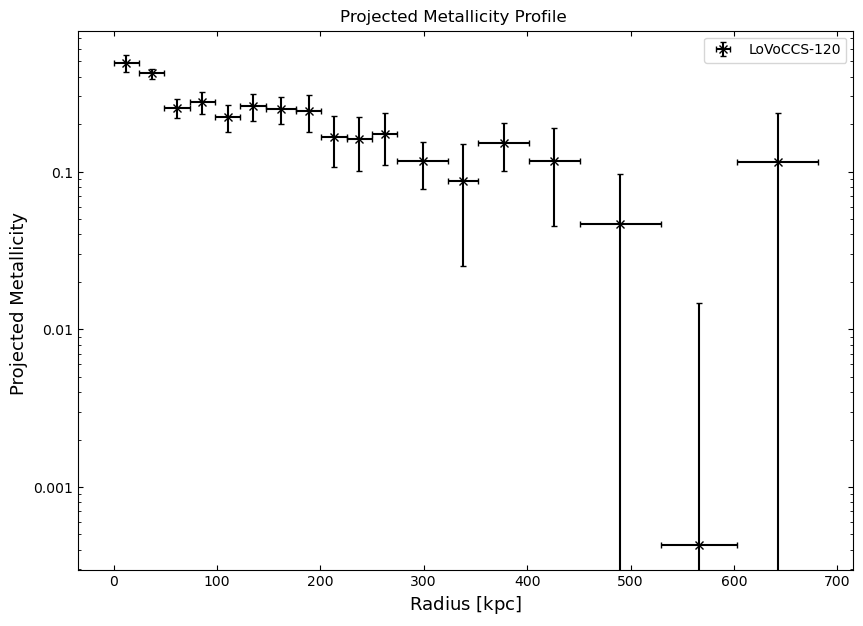

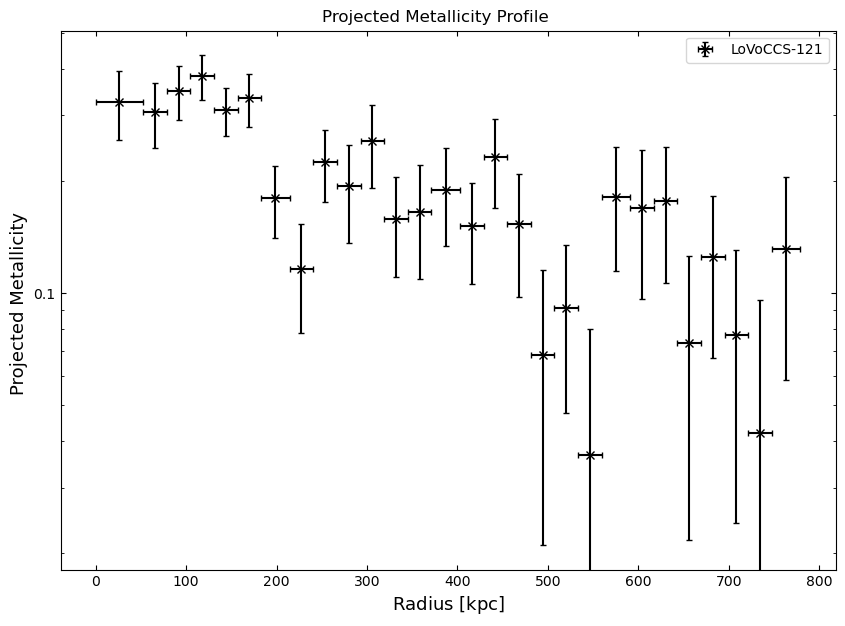

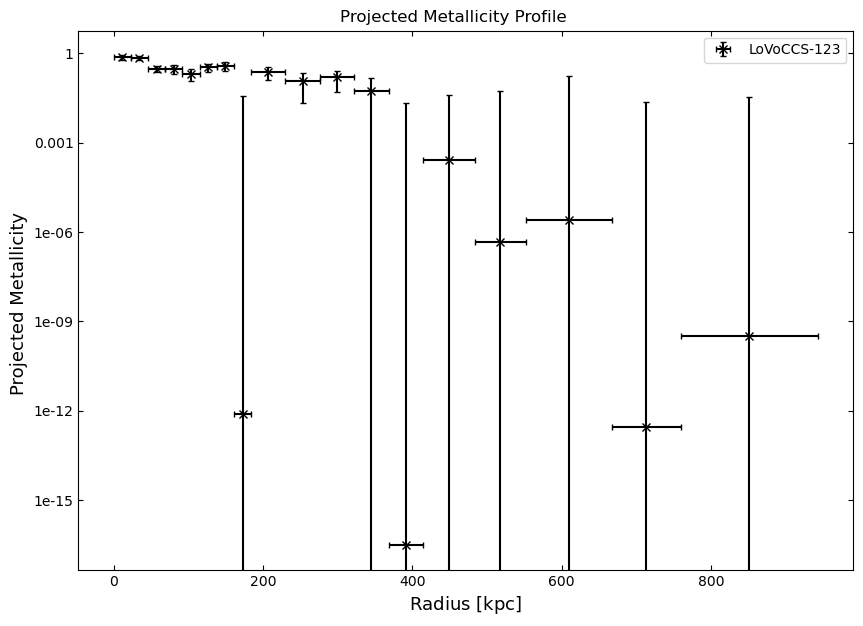

LoVoCCS-124


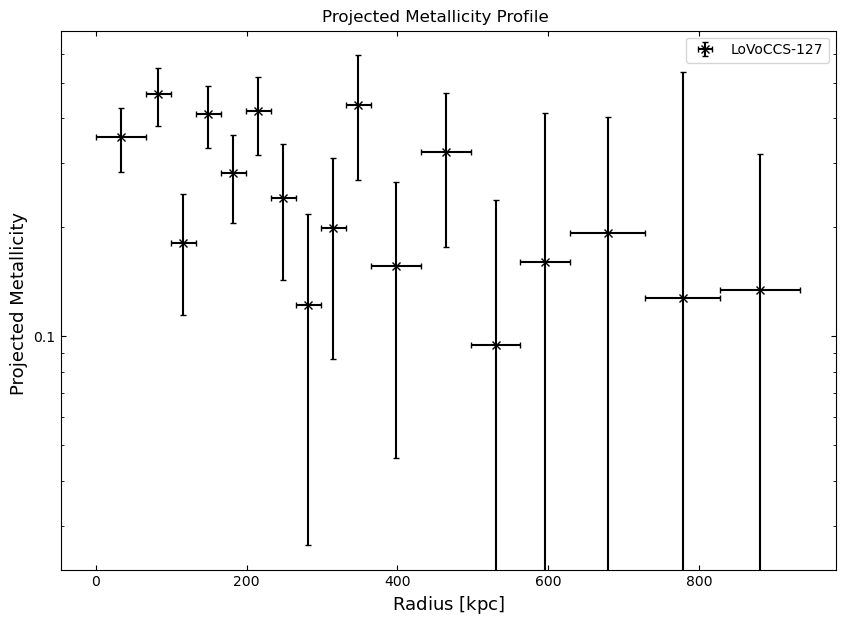

LoVoCCS-130


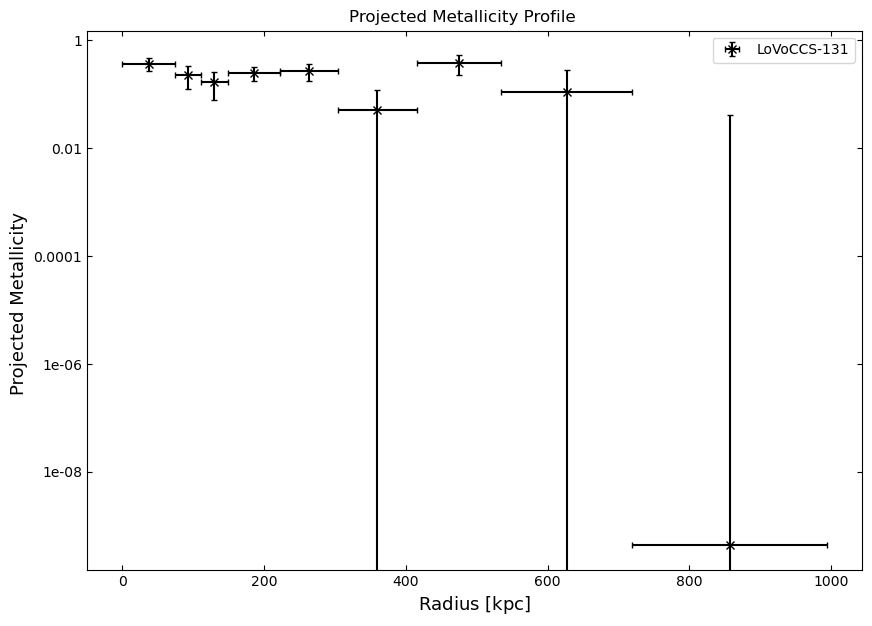

LoVoCCS-132


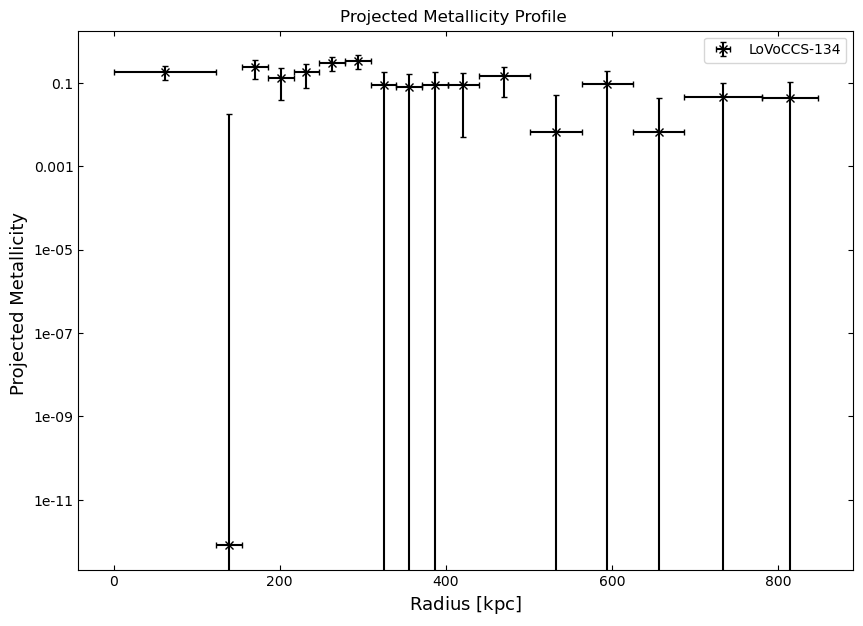

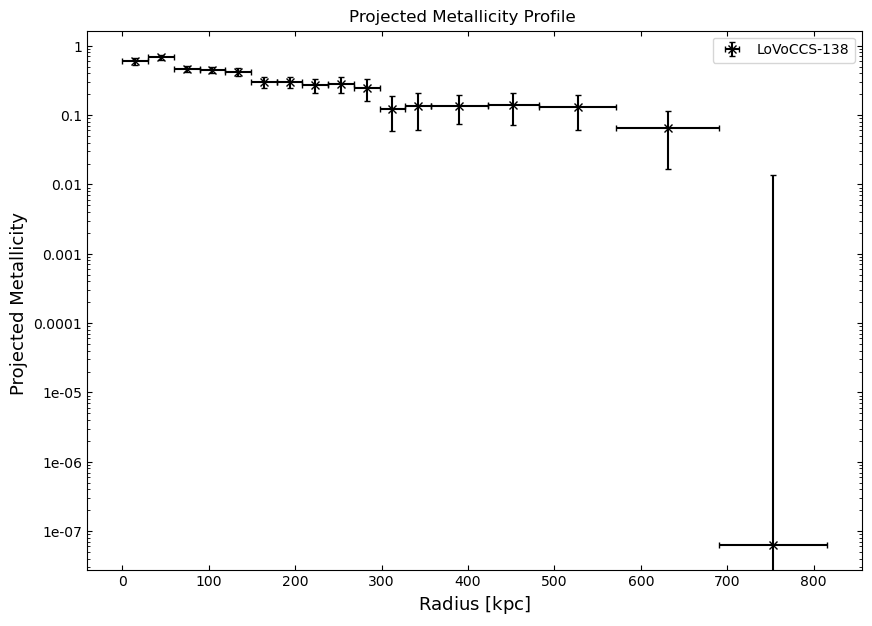

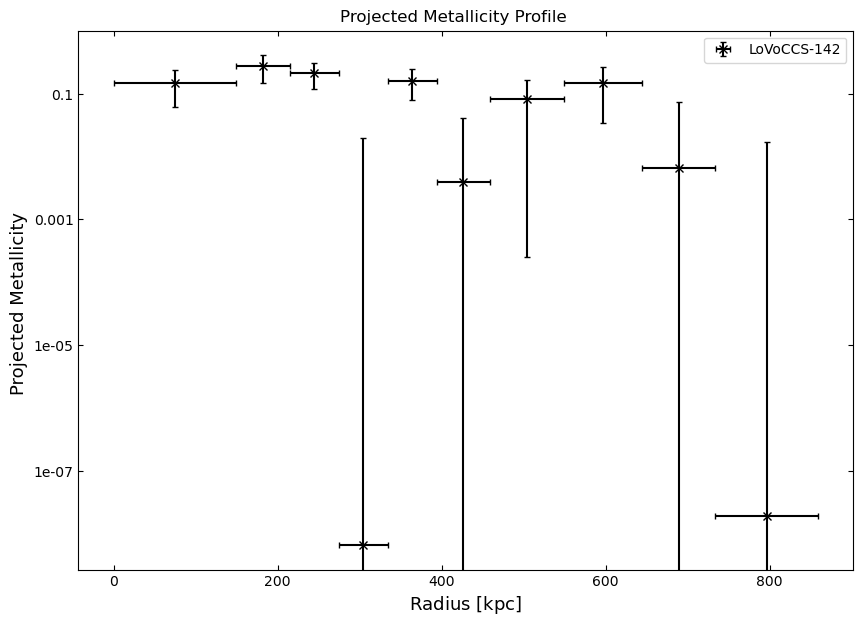

58

In [29]:
got_pm = 0
for src in srcs:
    try:
        pm = src.get_combined_profiles('1d_proj_metallicity')
        
        got_pm += 1
        if isinstance(pm, list):
            pm = BaseAggregateProfile1D(pm)
#         print(pt.set_ident)
        pm.view(xscale='linear')
    except NoProductAvailableError:
        print(src.name)
got_pm